In [1]:
import networkx as nx 
import matplotlib.pyplot as plt 
import matplotlib.cm as mplcm
import matplotlib
from matplotlib.gridspec import GridSpec
import numpy as np 
from scipy.stats import linregress
import math
import json
import subprocess
import pickle
from itertools import combinations, product
import os

In [2]:
def generate_colors(k, p):
    cm = plt.get_cmap('gist_rainbow')
    cNorm  = matplotlib.colors.Normalize(vmin=0, vmax=p*(k-1))
    scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)

    c = []
    for i in range(k):
        c.append(matplotlib.colors.to_hex(scalarMap.to_rgba(p*i)))
    return c

In [3]:
def random_subset(seq, m, rng):
    """Return m unique elements from seq.

    This differs from random.sample which can return repeated
    elements if seq holds repeated elements.

    Note: rng is a random.Random or numpy.random.RandomState instance.
    """
    targets = set()
    while len(targets) < m:
        x = rng.choice(seq)
        targets.add(x)
    return targets

In [4]:
def barabasi_albert_graph(n, m, embedding_layers_number, seed=None, initial_graph=None):
    """Returns a random graph using Barabási-Albert preferential attachment

    A graph of $n$ nodes is grown by attaching new nodes each with $m$
    edges that are preferentially attached to existing nodes with high degree.

    Parameters
    ----------
    n : int
        Number of nodes
    m : int
        Number of edges to attach from a new node to existing nodes
    seed : integer, random_state, or None (default)
        Indicator of random number generation state.
        See :ref:`Randomness<randomness>`.
    initial_graph : Graph or None (default)
        Initial network for Barabási-Albert algorithm.
        It should be a connected graph for most use cases.
        A copy of `initial_graph` is used.
        If None, starts from a star graph on (m+1) nodes.

    Returns
    -------
    G : Graph

    Raises
    ------
    NetworkXError
        If `m` does not satisfy ``1 <= m < n``, or
        the initial graph number of nodes m0 does not satisfy ``m <= m0 <= n``.

    References
    ----------
    .. [1] A. L. Barabási and R. Albert "Emergence of scaling in
       random networks", Science 286, pp 509-512, 1999.
    """

    if m < 1 or m >= n:
        raise nx.NetworkXError(
            f"Barabási-Albert network must have m >= 1 and m < n, m = {m}, n = {n}"
        )

    if initial_graph is None:
        # Default initial graph : star graph on (m + 1) nodes
        G = nx.star_graph(m)
    else:
        if len(initial_graph) < m or len(initial_graph) > n:
            raise nx.NetworkXError(
                f"Barabási-Albert initial graph needs between m={m} and n={n} nodes"
            )
        G = initial_graph.copy()

    for index, edge in enumerate(G.edges()):
        G.edges[edge]['color'] = 'blue' if index % embedding_layers_number == 0 else 'red'

    if seed is None:
        seed = np.random.RandomState()

    # List of existing nodes, with nodes repeated once for each adjacent edge
    repeated_nodes = [n for n, d in G.degree() for _ in range(d)]
    # Start adding the other n - m0 nodes.
    source = len(G)
    while source < n:
        # Now choose m unique nodes from the existing nodes
        # Pick uniformly from repeated_nodes (preferential attachment)
        targets = random_subset(repeated_nodes, m, seed)
        # Add edges to m nodes from the source.
        G.add_edges_from(zip([source] * m, targets))
        # Add one node to the list for each new edge just created.
        repeated_nodes.extend(targets)
        # And the new node "source" has m edges to add to the list.
        repeated_nodes.extend([source] * m)

        source += 1
    return G

In [5]:
def load_graph_from_file(file_path: str):
    """Load a graph from a file.

    Parameters
    ----------
    file_path : str
        The path to the file.
    """

    with open(file_path, 'r') as f:
        data = json.load(f)

    G = nx.Graph()

    for node in data['nodes']:
        if 'id' in node and 'color' in node:
            G.add_node(node['id'], color=node['color'])
        elif 'id' in node:
            G.add_node(node['id'])

    for edge in data['edges']:
        if 'source' in edge and 'target' in edge and 'color' in edge:
            G.add_edge(edge['source'], edge['target'], color=edge['color'])
        elif 'source' in edge and 'target' in edge and 'metrics' in edge:
            G.add_edge(edge['source'], edge['target'], metrics={'k33': float(edge['metrics']['k33']), 'k5': float(edge['metrics']['k5'])})
        elif 'source' in edge and 'target' in edge:
            G.add_edge(edge['source'], edge['target'])

    return G

def save_graph_to_file(G, file_path: str):
    """Save a graph to a file.

    Parameters
    ----------
    G : nx.Graph
        The graph to save.
    file_path : str
        The path to the file.
    """

    data = {
        'nodes': [],
        'edges': []
    }

    for node in G.nodes(data=True):
        data['nodes'].append({'id': node[0]})

    for edge in G.edges(data=True):
        data['edges'].append({'source': edge[0], 'target': edge[1]})

    with open(file_path, 'w') as f:
        json.dump(data, f)

In [6]:
EMBEDDING_COLORS = [
    '#1f77b4.txt',
    '#ff7f0e.txt',
    '#2ca02c.txt',
    '#d62728.txt',
    '#9467bd.txt',
    '#8c564b.txt',
    '#e377c2.txt',
    '#7f7f7f.txt',
    '#bcbd22.txt',
    '#17becf.txt'
]

def generate_graph(initial_nodes: int, final_nodes: int, edges_per_node: int):
    filename = 'graph.json'
    subprocess.run(['./implementation/graphs', 'G', str(initial_nodes), str(edges_per_node), str(final_nodes), filename])
    graph = load_graph_from_file(filename)
    
    os.remove(filename)
    
    return graph

def generate_graph_with_metric(initial_nodes: int, final_nodes: int, edges_per_node: int):
    filename = 'graph.json'
    subprocess.run(['./implementation/graphs', 'M', str(initial_nodes), str(edges_per_node), str(final_nodes), filename])
    graph = load_graph_from_file(filename)
    
    os.remove(filename)
    
    return graph

def generate_graph_with_embeddings(initial_nodes: int, final_nodes: int, edges_per_node: int, embeddings_number: int, output_dir: str):
    filename = 'graph.json'
    subprocess.run(['./implementation/graphs', 'C', str(initial_nodes), str(edges_per_node), str(final_nodes), str(embeddings_number), output_dir])

    graph = load_graph_from_file(f'{output_dir}/{filename}')
    embeddings = [load_graph_from_file(f'{output_dir}/embedding_{embedding_color}') for embedding_color in EMBEDDING_COLORS[:embeddings_number]]

    os.remove(f'{output_dir}/{filename}')

    times_x = []
    times_total_y = []
    times_metric_y = []
    times_merge_y = []
    with open(f'{output_dir}/times.txt', 'r') as f:
        for line in f.readlines():
            x, total_time, metric_time, merge_time = line.split()
            times_x.append(float(x))
            times_total_y.append(float(total_time))
            times_metric_y.append(float(metric_time))
            times_merge_y.append(float(merge_time))

    metrics = []
    for embedding_color in EMBEDDING_COLORS[:embeddings_number]:
        metric = [[[0,0] for _ in range(final_nodes)] for _ in range(final_nodes)]
        with open(f'{output_dir}/metrics_{embedding_color}', 'r') as f:
            metric_lines = [line.split('\n') for line in f.readlines()[1:]]
            metric_values = [line[0].replace(')', '').split('(')[1:] for line in metric_lines]
            for i in range(final_nodes):
                for j in range(final_nodes):
                    metric_k33, metric_k5 = metric_values[i][j].split(',')
                    metric[i][j] = [float(metric_k33.strip()), float(metric_k5.strip())]
        metrics.append(metric)

    return graph, embeddings, (times_x, times_total_y, times_metric_y, times_merge_y), metrics

def set_metric_for_graph(graph):
    in_filename = 'in-graph.json'
    out_filename = 'out-graph.json'

    save_graph_to_file(graph, in_filename)

    subprocess.run(['./implementation/graphs', 'S', in_filename, out_filename])
    graph = load_graph_from_file(out_filename)

    os.remove(in_filename)
    os.remove(out_filename)

    return graph

In [7]:
def draw_graph(G: nx.Graph, only_properties = False, name: str = 'BA Graph', pos: dict = None, hist_max_deg: int = None):
    fig = plt.figure(figsize=(14, 7))
    gs = GridSpec(2, 3, figure=fig)
    ax0 = fig.add_subplot(gs[:, :2])
    ax1 = fig.add_subplot(gs[0, 2])
    ax2 = fig.add_subplot(gs[1, 2])

    if not only_properties:
        node_colors = [G.nodes[node]['color'] if 'color' in G.nodes[node] else 'black' for node in G.nodes()]
        edge_colors = [G.edges[edge]['color'] if 'color' in G.edges[edge] else 'black' for edge in G.edges()]
        if pos == None:
            pos = nx.kamada_kawai_layout(G)
        nx.draw(G, pos, ax=ax0, node_color=node_colors, node_size=50, edge_color=edge_colors, with_labels=False)
        ax0.set_title(name)

    degrees = [G.degree(n) for n in G.nodes()]

    if hist_max_deg == None:
        hist_max_deg = max(degrees) + 2
    ax1.hist(degrees, bins=range(1, hist_max_deg), align='left', color='deepskyblue')
    ax1.set_title("Degree Histogram")
    ax1.set_xlabel("Degree")
    ax1.set_ylabel("Frequency")

    degree_counts = np.bincount(degrees)[1:]
    cdf = np.cumsum(degree_counts[::-1])[::-1]
    cdf = cdf / cdf[0]

    nonzero_indices = degree_counts > 0
    k = np.arange(1, len(degree_counts) + 1)[nonzero_indices]
    cdf = cdf[nonzero_indices]

    log_k = np.log(k)
    log_cdf = np.log(cdf)

    slope, intercept, r_value, p_value, std_err = linregress(log_k, log_cdf)
    lambda_estimate = -(slope - 1)

    ax2.scatter(k, cdf, s=10, alpha=0.75, label='Degree CDF', color='deepskyblue')
    ax2.plot(k, np.exp(intercept) * k ** slope, label=f'Power-law fit: $\\lambda = {lambda_estimate:.3f}$', color='deeppink')

    ax2.set_xscale('log')
    ax2.set_yscale('log')
    ax2.set_xlabel('Degree')
    ax2.set_ylabel('CDF')
    ax2.set_title('Degree Distribution and Power-law Fit')
    ax2.legend()

    plt.tight_layout()
    plt.show()

    return pos, hist_max_deg

In [77]:
def visualise_metric(ax, metric, with_labels, title, edge_cmap, edge_min_normalizer, edge_max_normalizer, vertex_cmap, vertex_min_normalizer, vertex_max_normalizer, pos=None, edge_threshold=None, label_threshold=None):
    if edge_threshold == None:
        edge_threshold = edge_min_normalizer
    if label_threshold == None:
        label_threshold = edge_min_normalizer

    n = len(metric)

    G = nx.Graph()
    for i in range(n):
        G.add_node(i)

    for i in range(n):
        for j in range(i+1, n):
            if metric[i][j] >= edge_threshold and metric[i][j] != 0:
                G.add_edge(i, j, weight=metric[i][j])

    edge_weights = nx.get_edge_attributes(G, 'weight')
    edge_colors = [edge_weights[edge] for edge in G.edges()]
    node_colors = [metric[i][i] for i in G.nodes()]

    if pos == None:
        pos = nx.kamada_kawai_layout(G)

    nx.draw_networkx_nodes(G, pos, ax=ax, node_size=50, node_color=node_colors, cmap=vertex_cmap, vmin=vertex_min_normalizer, vmax=vertex_max_normalizer)
    nx.draw_networkx_edges(G, pos, ax=ax, edge_color=edge_colors, edge_cmap=edge_cmap, edge_vmin=edge_min_normalizer, edge_vmax=edge_max_normalizer)

    if with_labels:
        nx.draw_networkx_edge_labels(G, pos, ax=ax, edge_labels=edge_weights, font_color='black', font_size=6)

    ax.set_title(title)


def visualise_metrics(metric, metric_num, with_labels, edge_cmap, edge_min_normalizer, edge_max_normalizer, vertex_cmap, vertex_min_normalizer, vertex_max_normalizer, pos=None, edge_threshold=None, label_threshold=None):
    fig = plt.figure(figsize=(14, 7))
    gs = GridSpec(1, 2, figure=fig)
    ax_k33 = fig.add_subplot(gs[0, 0])
    ax_k5 = fig.add_subplot(gs[0, 1])

    k33_metric = [[item[0] for item in row] for row in metric]
    k5_metric = [[item[1] for item in row] for row in metric]

    visualise_metric(ax_k33, k33_metric, with_labels, f"Metric K33 for {EMBEDDING_COLORS[metric_num].replace('.txt', '')}", edge_cmap, edge_min_normalizer, edge_max_normalizer, vertex_cmap, vertex_min_normalizer, vertex_max_normalizer, pos, edge_threshold, label_threshold)
    visualise_metric(ax_k5, k5_metric, with_labels, f"Metric K5 for {EMBEDDING_COLORS[metric_num].replace('.txt', '')}", edge_cmap, edge_min_normalizer, edge_max_normalizer, vertex_cmap, vertex_min_normalizer, vertex_max_normalizer, pos, edge_threshold, label_threshold)

    plt.tight_layout()
    plt.show()

def visualise_metric_on_graph(ax, graph, metric, with_labels, title, edge_cmap, edge_min_normalizer, edge_max_normalizer, vertex_cmap, vertex_min_normalizer, vertex_max_normalizer, pos=None):
    edge_weights = {(edge[0], edge[1]): metric[edge[0]][edge[1]] for edge in graph.edges()}
    edge_colors = [metric[edge[0]][edge[1]] for edge in graph.edges()]
    node_colors = [metric[i][i] for i in graph.nodes()]

    if pos == None:
        pos = nx.kamada_kawai_layout(graph)

    nx.draw_networkx_nodes(graph, pos, ax=ax, node_size=50, node_color=node_colors, cmap=vertex_cmap, vmin=vertex_min_normalizer, vmax=vertex_max_normalizer)
    nx.draw_networkx_edges(graph, pos, ax=ax, edge_color=edge_colors, edge_cmap=edge_cmap, edge_vmin=edge_min_normalizer, edge_vmax=edge_max_normalizer)

    if with_labels:
        nx.draw_networkx_edge_labels(edge_colors, pos, ax=ax, edge_labels=edge_weights, font_color='black', font_size=6)


    ax.set_title(title)

def visualise_metrics_on_graph(graph, metric, with_labels, title, edge_cmap, edge_min_normalizer, edge_max_normalizer, vertex_cmap, vertex_min_normalizer, vertex_max_normalizer, pos=None):
    fig = plt.figure(figsize=(14, 7))
    gs = GridSpec(1, 2, figure=fig)
    ax_k33 = fig.add_subplot(gs[0, 0])
    ax_k5 = fig.add_subplot(gs[0, 1])

    k33_metric = [[item[0] for item in row] for row in metric]
    k5_metric = [[item[1] for item in row] for row in metric]

    visualise_metric_on_graph(ax_k33, graph, k33_metric, with_labels, title, edge_cmap, edge_min_normalizer, edge_max_normalizer, vertex_cmap, vertex_min_normalizer, vertex_max_normalizer, pos)
    visualise_metric_on_graph(ax_k5, graph, k5_metric, with_labels, title, edge_cmap, edge_min_normalizer, edge_max_normalizer, vertex_cmap, vertex_min_normalizer, vertex_max_normalizer, pos)

    plt.tight_layout()
    plt.show()

In [42]:
def visualise_times(times):
    fig = plt.figure(figsize=(14, 7))
    gs = GridSpec(1, 3, figure=fig)
    ax_total = fig.add_subplot(gs[0, 0])
    ax_metric = fig.add_subplot(gs[0, 1])
    ax_merge = fig.add_subplot(gs[0, 2])

    times_x, times_total_y, times_metric_y, times_merge_y = times

    ax_total.plot(times_x, times_total_y, label='Total time', color='deepskyblue')
    ax_total.set_title('Total time')
    ax_total.set_xlabel('Number of nodes')
    ax_total.set_ylabel('Time (s)')

    ax_metric.plot(times_x, times_metric_y, label='Metric time', color='deepskyblue')
    ax_metric.set_title('Metric time')
    ax_metric.set_xlabel('Number of nodes')
    ax_metric.set_ylabel('Time (s)')

    ax_merge.plot(times_x, times_merge_y, label='Merge time', color='deepskyblue')
    ax_merge.set_title('Merge time')
    ax_merge.set_xlabel('Number of nodes')
    ax_merge.set_ylabel('Time (s)')

    plt.tight_layout()
    plt.show()

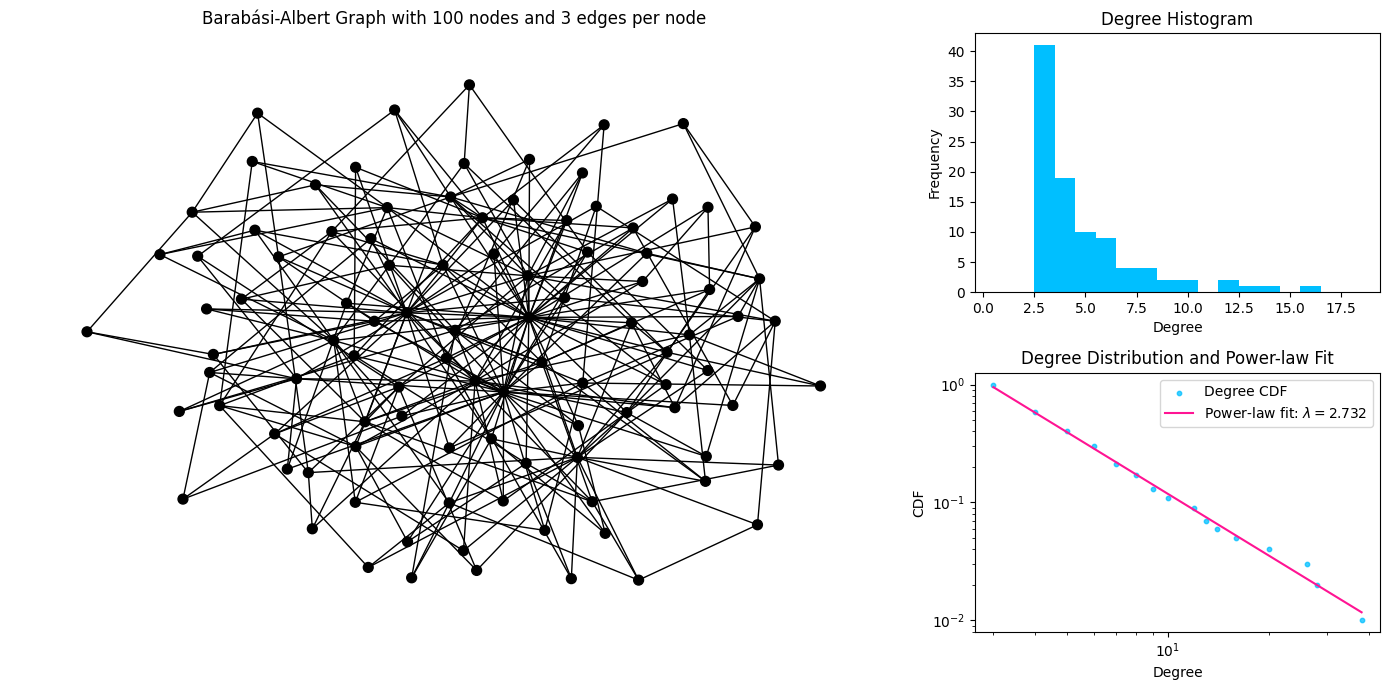

In [29]:
INITIAL_NODES = 5
FINAL_NODES = 100
EDGES_PER_NODE = 3

graph = generate_graph(INITIAL_NODES, FINAL_NODES, EDGES_PER_NODE)

planar_info = 'is planar' if nx.is_planar(graph) else 'is not planar'
pos, hist_max_deg = draw_graph(graph, name=f'Barabási-Albert Graph with {FINAL_NODES} nodes and {EDGES_PER_NODE} edges per node', hist_max_deg=20)


Color: #1f77b4 metric: 0.563501
Color: #ff7f0e metric: 0.563501
Painting edge: 0 1 to #ff7f0e

Color: #1f77b4 metric: 0.52571
Color: #ff7f0e metric: 0.186997
Painting edge: 1 2 to #ff7f0e

Color: #1f77b4 metric: 0.562035
Color: #ff7f0e metric: -0.18695
Painting edge: 2 3 to #ff7f0e

Color: #1f77b4 metric: 0.652184
Color: #ff7f0e metric: -0.564529
Painting edge: 3 4 to #ff7f0e

Color: #1f77b4 metric: 0.652184
Color: #ff7f0e metric: -3.28426
Painting edge: 0 4 to #1f77b4

Color: #1f77b4 metric: -5.56852
Color: #ff7f0e metric: -0.944779
Painting edge: 0 5 to #ff7f0e

Color: #1f77b4 metric: 1.31221
Color: #ff7f0e metric: -4.58063
Painting edge: 3 5 to #1f77b4

Color: #1f77b4 metric: -3.62797
Color: #ff7f0e metric: -3.94112
Painting edge: 4 5 to #1f77b4

Color: #1f77b4 metric: -2.45265
Color: #ff7f0e metric: -3.23192
Painting edge: 1 6 to #1f77b4

Color: #1f77b4 metric: -2.81697
Color: #ff7f0e metric: -3.38544
Painting edge: 3 6 to #1f77b4

Color: #1f77b4 metric: -4.52808
Color: #ff7f0e me

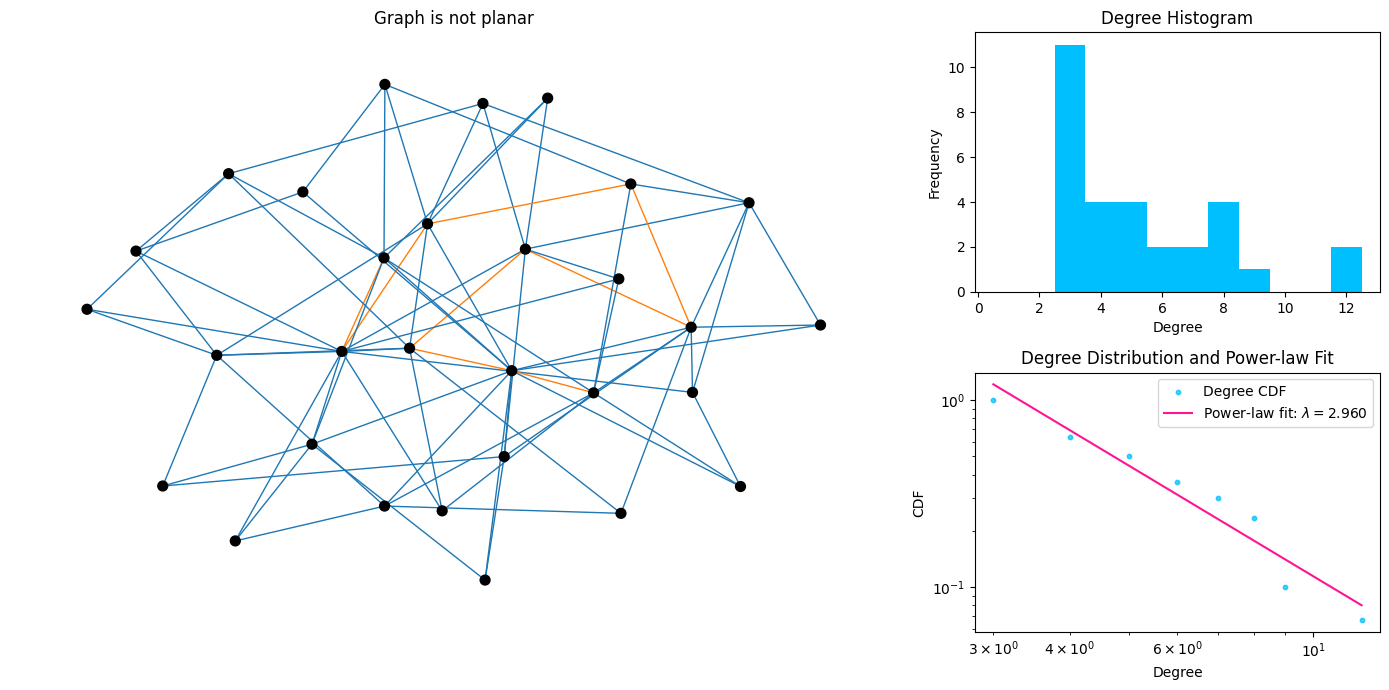

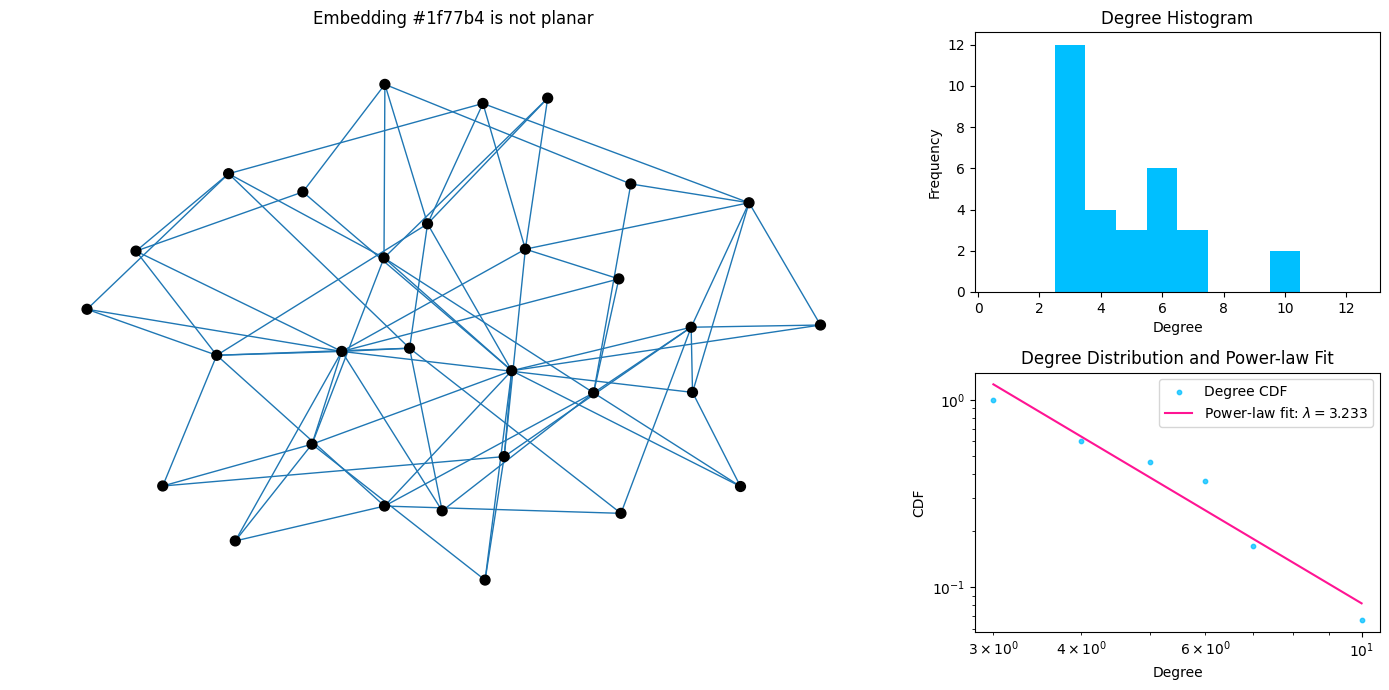

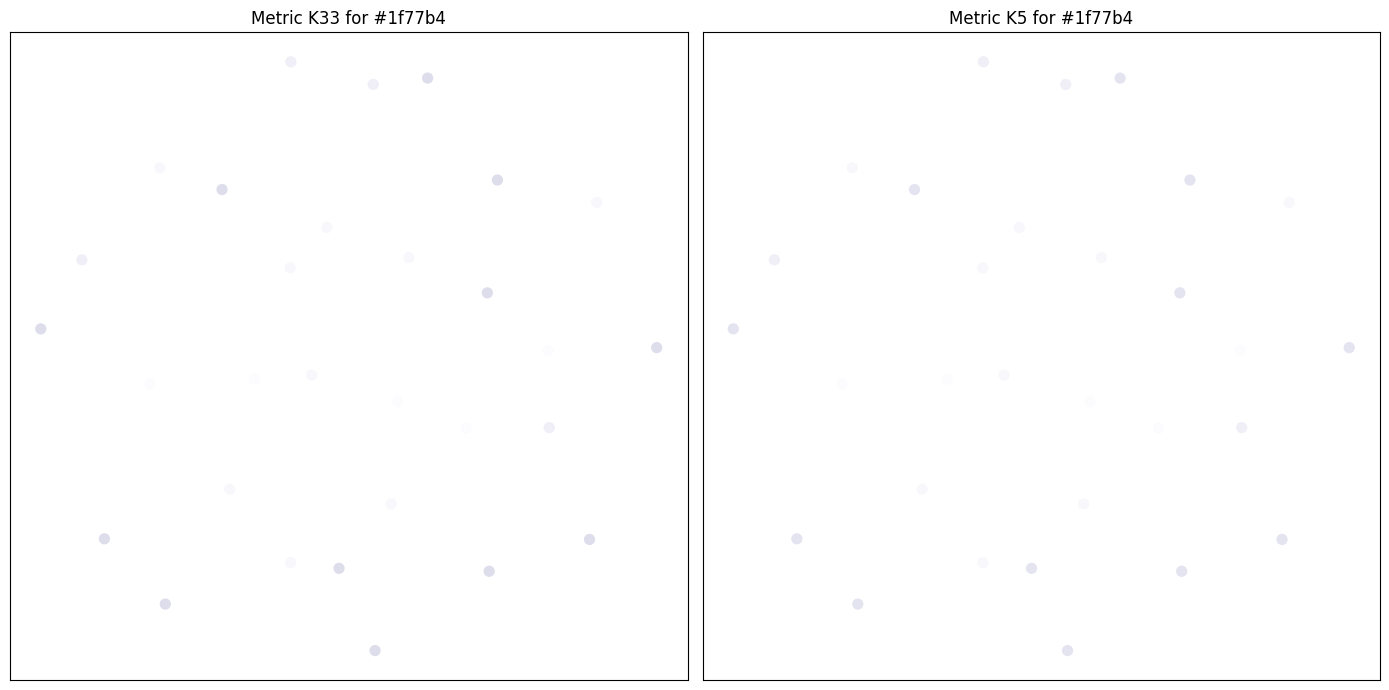

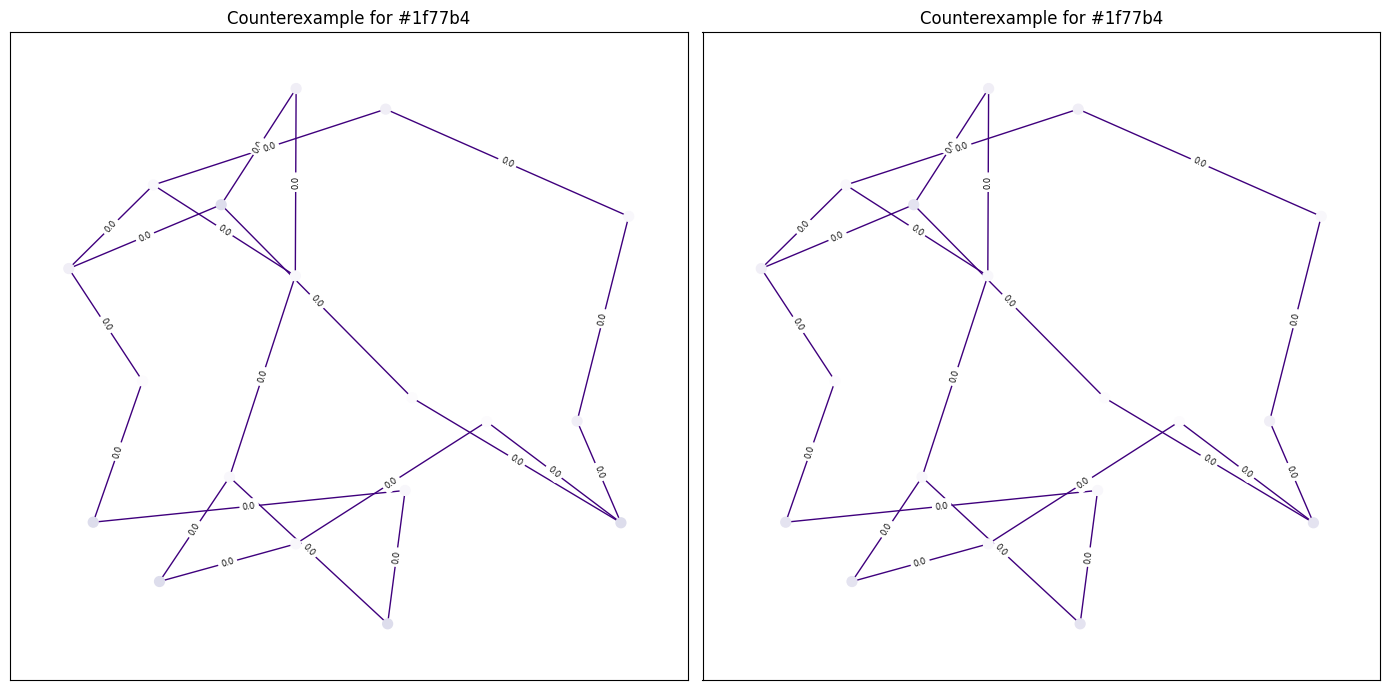

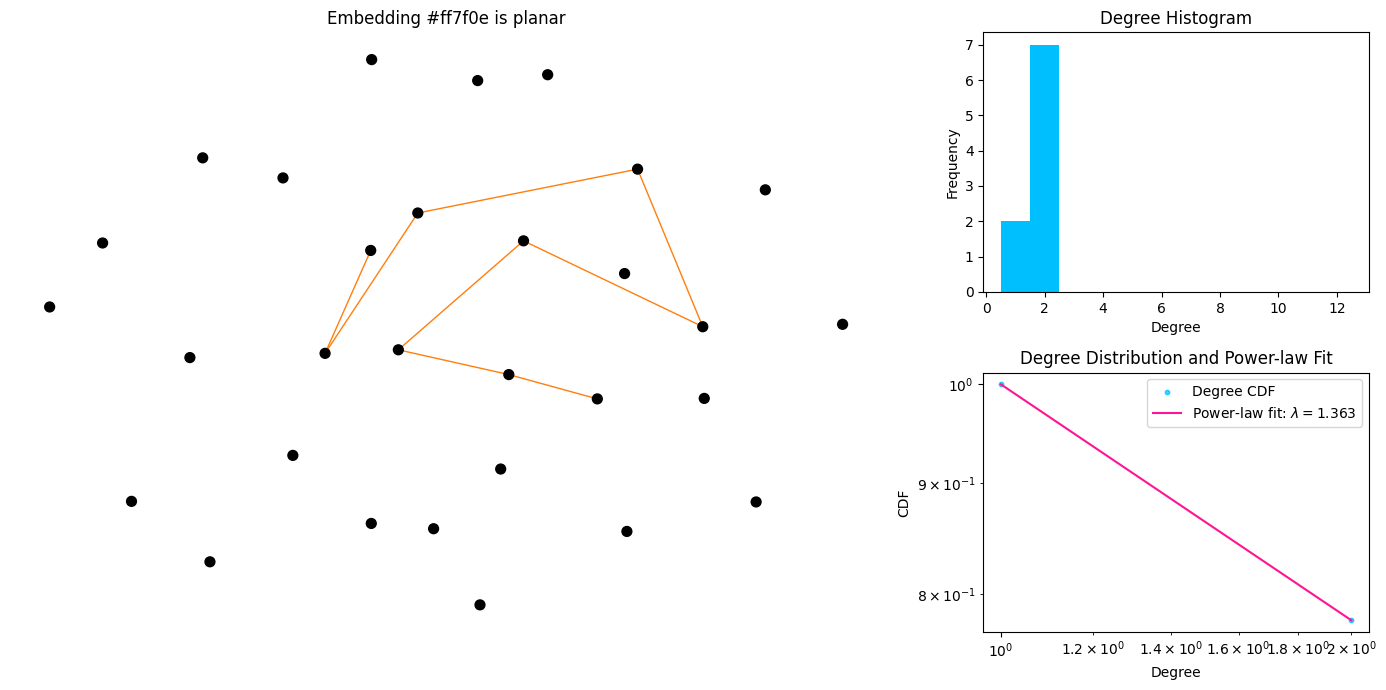

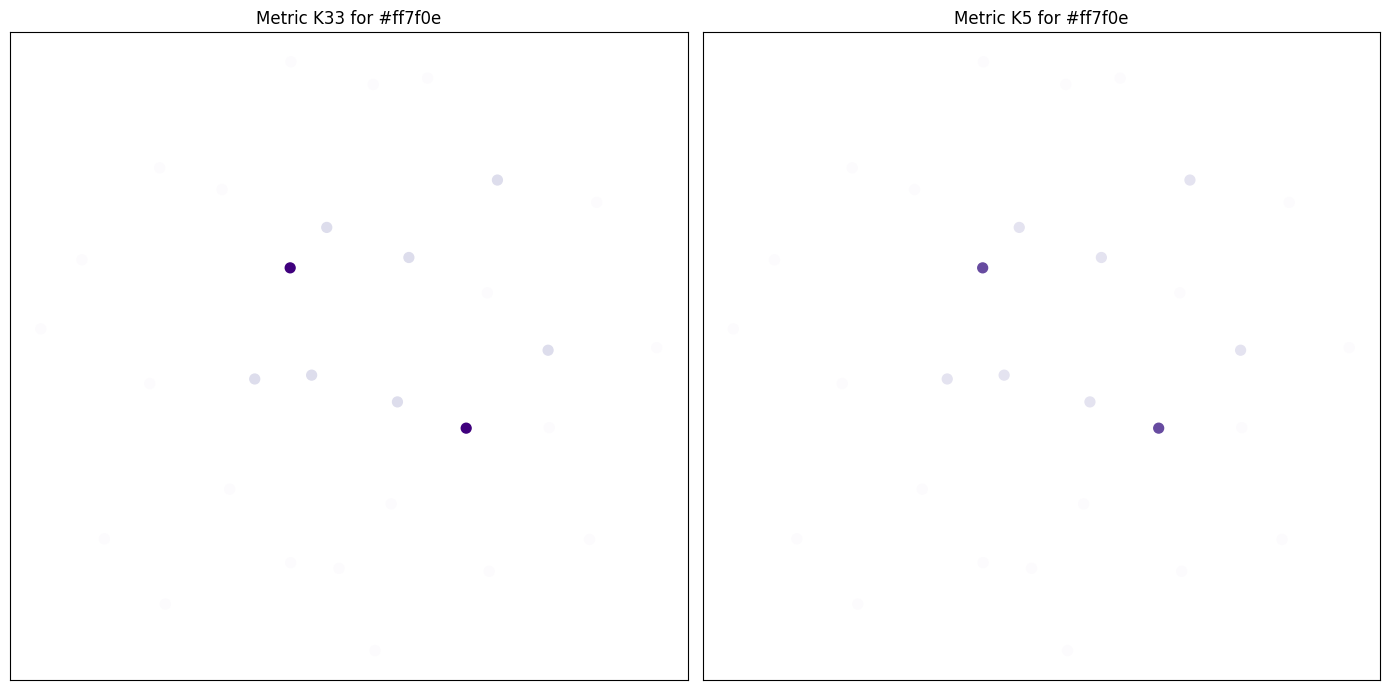

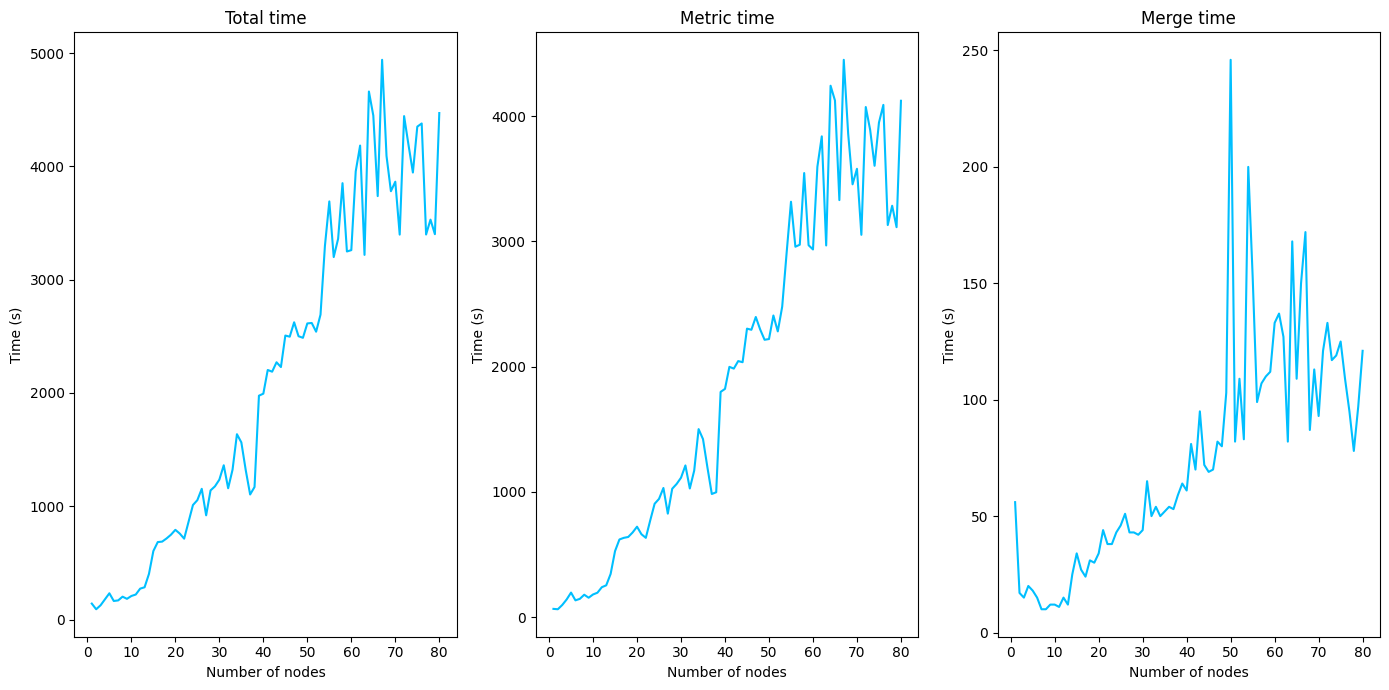

In [283]:
INITIAL_NODES = 5
FINAL_NODES = 30
EDGES_PER_NODE = 3
EMBEDDING_NUMBERS = 2

DRAW_THRESHOLD = 1

ba, embbs, times, metrics = generate_graph_with_embeddings(INITIAL_NODES, FINAL_NODES, EDGES_PER_NODE, EMBEDDING_NUMBERS, 'out')

all_edge_metric_values = []
all_vertex_metric_values = []
for metric in metrics:
    for i in range(FINAL_NODES):
        for j in range(FINAL_NODES):
            if i != j:
                all_edge_metric_values.append(metric[i][j][0])
                all_edge_metric_values.append(metric[i][j][1])
            else:
                all_vertex_metric_values.append(metric[i][j][0])
                all_vertex_metric_values.append(metric[i][j][1])

sorted_edge_metric_values = sorted(all_edge_metric_values)
sorted_vertex_metric_values = sorted(all_vertex_metric_values)

min_edge_metric_value = sorted_edge_metric_values[0]
max_edge_metric_value = sorted_edge_metric_values[-1]

min_vertex_metric_value = sorted_vertex_metric_values[0]
max_vertex_metric_value = sorted_vertex_metric_values[-1]

planar_info = 'is planar' if nx.is_planar(ba) else 'is not planar'
pos, hist_max_deg = draw_graph(ba, False, 'Graph ' + planar_info, None, None)

for index, embb in enumerate(embbs):
    is_planar, counterexample = nx.check_planarity(embb, True)
    planar_info = ' is planar'if is_planar else ' is not planar'
    draw_graph(embb, False, 'Embedding ' + EMBEDDING_COLORS[index].replace('.txt', '') + planar_info, pos, hist_max_deg)
    visualise_metrics(metrics[index], index, True, plt.cm.Purples, min_edge_metric_value, max_edge_metric_value, plt.cm.Purples, min_vertex_metric_value, max_vertex_metric_value, pos, DRAW_THRESHOLD, DRAW_THRESHOLD)

    if not is_planar:
        # draw_graph(counterexample, False, 'Counterexample for ' + EMBEDDING_COLORS[index].replace('.txt', ''), pos, hist_max_deg)
        visualise_metrics_on_graph(counterexample, metrics[index], True, f'Counterexample for {EMBEDDING_COLORS[index].replace(".txt", "")}', plt.cm.Purples, min_edge_metric_value, max_edge_metric_value, plt.cm.Purples, min_vertex_metric_value, max_vertex_metric_value, pos)

visualise_times(times)

# print('Metrics:')
# for index, metric in enumerate(metrics):
#     print(f'Embedding {index + 1}:')
#     for i in range(FINAL_NODES):
#         for j in range(FINAL_NODES):
#             print(f'({metric[i][j][0]:.3f}, {metric[i][j][1]:.3f})', end=' ')
#         print()
#     print()

# for emmb in embbs:
#     set_metric_for_graph(emmb)

In [262]:
def mst_embeddings_without_weights(G, complement=False):
    msts = []
    while G.number_of_edges() > 0:
        if nx.is_planar(G):
            msts.append(G)
            break
        
        mst = nx.minimum_spanning_tree(G)
        for edge in mst.edges():
            G.remove_edge(*edge)
    
        if complement:
            for edge in G.edges():
                mst.add_edge(*edge)
                if 'metrics' in G.edges[edge]:
                    mst.edges[edge]['metrics'] = G.edges[edge]['metrics']
                if nx.is_planar(mst):
                    G.remove_edge(*edge)
                else:
                    mst.remove_edge(*edge)

        msts.append(mst)

    return msts

def mst_embeddings_with_weights(G, complement=False):
    msts = []
    while G.number_of_edges() > 0:
        G = set_metric_for_graph(G)
        for edge in G.edges():
            G.edges[edge]['weight'] = (499 * G.edges[edge]['metrics']['k33'] + 1 * G.edges[edge]['metrics']['k5']) / 500
            
        mst = nx.minimum_spanning_tree(G, weight='weight')
        for edge in mst.edges():
            G.remove_edge(*edge)
    
        if complement:
            for edge in sorted(G.edges(), key=lambda edge: G.edges[edge]['weight'], reverse=False):
                mst.add_edge(*edge)
                if 'metrics' in G.edges[edge]:
                    mst.edges[edge]['metrics'] = G.edges[edge]['metrics']
                if nx.is_planar(mst):
                    mst
                    G.remove_edge(*edge)
                else:
                    mst.remove_edge(*edge)

        msts.append(mst)
    
    return msts

In [243]:
def cactus_embeddings_without_weights(G, complement=False):
    def check_triangle_in_different_components(components, triangle):
        return len({comp_id for node in triangle for comp_id, comp in enumerate(components) if node in comp}) == 3

    def check_edge_in_different_components(components, edge):
        u,v = edge
        u_comp = next(comp_id for comp_id, comp in enumerate(components) if u in comp)
        v_comp = next(comp_id for comp_id, comp in enumerate(components) if v in comp)
        return u_comp != v_comp
    
    def find_cactus_structure(G):
        E1 = nx.Graph()
        for node in G.nodes():
            E1.add_node(node)

        while True:
            components = list(nx.connected_components(E1))
            changed = False
            for triangle in [triangle for triangle in nx.enumerate_all_cliques(G) if len(triangle) == 3]:
                if check_triangle_in_different_components(components, triangle):
                    E1.add_edges_from([(triangle[i], triangle[j]) for i in range(3) for j in range(i+1, 3)])
                    components = list(nx.connected_components(E1))
                    changed = True

            if not changed:
                break
            
        
        while True:
            components = list(nx.connected_components(E1))
            changed = False
            for edge in G.edges():
                if check_edge_in_different_components(components, edge):
                    E1.add_edge(*edge)
                    components = list(nx.connected_components(E1))
                    changed = True

            if not changed:
                break
        
        return E1
    
    cactuses = []
    while G.number_of_edges() > 0: 
        cactus = find_cactus_structure(G)
        for edge in cactus.edges():
            G.remove_edge(*edge)

        if complement:
            for edge in G.edges():
                cactus.add_edge(*edge)
                if nx.is_planar(cactus):
                    G.remove_edge(*edge)
                else:
                    cactus.remove_edge(*edge)
    
        cactuses.append(cactus)

    return cactuses

def cactus_embeddings_with_weights(G, complement=False):
    def check_triangle_in_different_components(components, triangle):
        return len({comp_id for node in triangle for comp_id, comp in enumerate(components) if node in comp}) == 3

    def check_edge_in_different_components(components, edge):
        u,v = edge
        u_comp = next(comp_id for comp_id, comp in enumerate(components) if u in comp)
        v_comp = next(comp_id for comp_id, comp in enumerate(components) if v in comp)
        return u_comp != v_comp
    
    def triangle_key(triangle, G):
        return sum([G.edges[(triangle[i], triangle[j])]['weight'] for i in range(3) for j in range(i+1, 3)])
    
    def find_cactus_structure(G):
        E1 = nx.Graph()
        for node in G.nodes():
            E1.add_node(node)

        while True:
            components = list(nx.connected_components(E1))
            changed = False
            triangles = [triangle for triangle in nx.enumerate_all_cliques(G) if len(triangle) == 3]
            sorted(triangles, key=lambda triangle: triangle_key(triangle, G), reverse=False)
            for triangle in triangles:
                if check_triangle_in_different_components(components, triangle):
                    E1.add_edges_from([(triangle[i], triangle[j]) for i in range(3) for j in range(i+1, 3)])
                    components = list(nx.connected_components(E1))
                    changed = True

            if not changed:
                break
            
        
        while True:
            components = list(nx.connected_components(E1))
            changed = False
            for edge in sorted(G.edges(), key=lambda edge: G.edges[edge]['weight'], reverse=False):
                if check_edge_in_different_components(components, edge):
                    E1.add_edge(*edge)
                    components = list(nx.connected_components(E1))
                    changed = True

            if not changed:
                break
        
        return E1
    
    cactuses = []
    while G.number_of_edges() > 0: 
        G = set_metric_for_graph(G)
        for edge in G.edges():
            G.edges[edge]['weight'] = (499 * G.edges[edge]['metrics']['k33'] + 1 * G.edges[edge]['metrics']['k5']) / 500

        cactus = find_cactus_structure(G)
        for edge in cactus.edges():
            G.remove_edge(*edge)

        if complement:
            for edge in G.edges():
                cactus.add_edge(*edge)
                if 'metrics' in G.edges[edge]:
                    cactus.edges[edge]['metrics'] = G.edges[edge]['metrics']
                if nx.is_planar(cactus):
                    G.remove_edge(*edge)
                else:
                    cactus.remove_edge(*edge)
    
        cactuses.append(cactus)

    return cactuses

In [364]:
def mst_embeddings_without_weights_given_size(G, embbeddings_number):
    for edge in G.edges():
        G.edges[edge]['weight'] = (499 * G.edges[edge]['metrics']['k33'] + 1 * G.edges[edge]['metrics']['k5']) / 500
            
    msts = []
    for _ in range(embbeddings_number):
        mst = nx.minimum_spanning_tree(G)
        for edge in mst.edges():
            G.remove_edge(*edge)
        msts.append(mst)

    for edge in sorted(G.edges(), key=lambda edge: G.edges[edge]['weight'], reverse=False):
        for mst_index in range(embbeddings_number):
            msts[mst_index].add_edge(*edge)
            if 'metrics' in G.edges[edge]:
                msts[mst_index].edges[edge]['metrics'] = G.edges[edge]['metrics']
            
            if nx.is_planar(msts[mst_index]):
                G.remove_edge(*edge)
                break
            else:
                msts[mst_index].remove_edge(*edge)

            mst_index = (mst_index + 1) % embbeddings_number
            
    return msts, G.edges()

In [93]:
def get_ratio(graph: nx.Graph, edge_numbers: list[int]):
    max_edges_number = 3 * graph.number_of_nodes() - 6

    return [edge_number / max_edges_number for edge_number in edge_numbers]

In [365]:
INITIAL_NODES = 10
FINAL_NODES = 100
EDGES_PER_NODE = 3

graph = generate_graph_with_metric(INITIAL_NODES, FINAL_NODES, EDGES_PER_NODE)

msts = mst_embeddings_without_weights(graph.copy(), True)
msts2, remaining_edges = mst_embeddings_without_weights_given_size(graph.copy(), 2)

print([len(mst.edges()) for mst in msts])
print([len(mst.edges()) for mst in msts2])
print(len(remaining_edges))

print(get_ratio(graph, [len(mst.edges()) for mst in msts]))
print(get_ratio(graph, [len(mst.edges()) for mst in msts2]))

[165, 106, 9]
[99, 98, 83]
0
[0.5612244897959183, 0.36054421768707484, 0.030612244897959183]
[0.336734693877551, 0.3333333333333333, 0.282312925170068]


In [340]:
INITIAL_NODES = 10
FINAL_NODES = 100
EDGES_PER_NODE = 4

graph = generate_graph_with_metric(INITIAL_NODES, FINAL_NODES, EDGES_PER_NODE)

mst_method = mst_embeddings_without_weights(graph.copy(), True)
mst_with_weights_method = mst_embeddings_with_weights(graph.copy(), True)

cactus_method = cactus_embeddings_without_weights(graph.copy(), True)
cactus_with_weights_method = cactus_embeddings_with_weights(graph.copy(), True)

print([len(m.edges()) for m in mst_method])
print([len(m.edges()) for m in mst_with_weights_method])

print([len(m.edges()) for m in cactus_method])
print([len(m.edges()) for m in cactus_with_weights_method])

print(get_ratio(graph, [len(m.edges()) for m in mst_method]))
print(get_ratio(graph, [len(m.edges()) for m in mst_with_weights_method]))

print(get_ratio(graph, [len(m.edges()) for m in cactus_method]))
print(get_ratio(graph, [len(m.edges()) for m in cactus_with_weights_method]))

[177, 136, 57]
[196, 129, 45]
[183, 135, 52]
[188, 133, 49]
[0.6020408163265306, 0.46258503401360546, 0.19387755102040816]
[0.6666666666666666, 0.4387755102040816, 0.15306122448979592]
[0.6224489795918368, 0.45918367346938777, 0.17687074829931973]
[0.6394557823129252, 0.4523809523809524, 0.16666666666666666]


m = 2
n = 30
Iteration 0
Iteration 1
Iteration 2
Iteration 3
Iteration 4
Iteration 5
Iteration 6
Iteration 7
Iteration 8
Iteration 9
Iteration 10
Iteration 11
Iteration 12
Iteration 13
Iteration 14
Iteration 15
Iteration 16
Iteration 17
Iteration 18
Iteration 19
Iteration 20
Iteration 21
Iteration 22
Iteration 23
Iteration 24
Iteration 25
Iteration 26
Iteration 27
Iteration 28
Iteration 29
Iteration 30
Iteration 31
Iteration 32
Iteration 33
Iteration 34
Iteration 35
Iteration 36
Iteration 37
Iteration 38
Iteration 39
Iteration 40
Iteration 41
Iteration 42
Iteration 43
Iteration 44
Iteration 45
Iteration 46
Iteration 47
Iteration 48
Iteration 49
Iteration 50
Iteration 51
Iteration 52
Iteration 53
Iteration 54
Iteration 55
Iteration 56
Iteration 57
Iteration 58
Iteration 59
Iteration 60
Iteration 61
Iteration 62
Iteration 63
Iteration 64
Iteration 65
Iteration 66
Iteration 67
Iteration 68
Iteration 69
Iteration 70
Iteration 71
Iteration 72
Iteration 73
Iteration 74
Iteration 75
Iteration

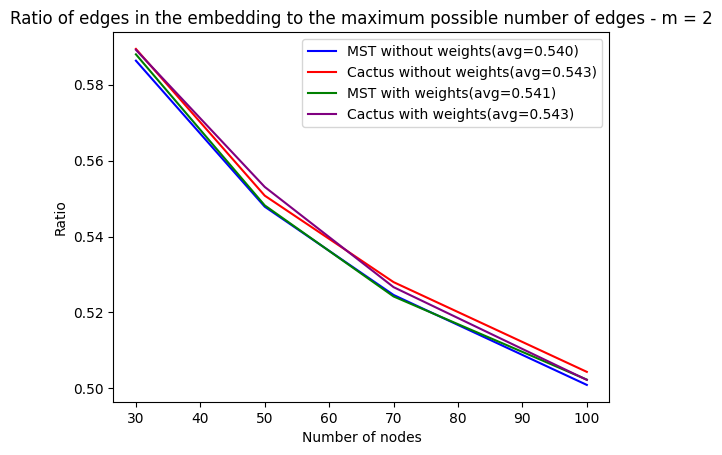

m = 3
n = 30
Iteration 0
Iteration 1
Iteration 2
Iteration 3
Iteration 4
Iteration 5
Iteration 6
Iteration 7
Iteration 8
Iteration 9
Iteration 10
Iteration 11
Iteration 12
Iteration 13
Iteration 14
Iteration 15
Iteration 16
Iteration 17
Iteration 18
Iteration 19
Iteration 20
Iteration 21
Iteration 22
Iteration 23
Iteration 24
Iteration 25
Iteration 26
Iteration 27
Iteration 28
Iteration 29
Iteration 30
Iteration 31
Iteration 32
Iteration 33
Iteration 34
Iteration 35
Iteration 36
Iteration 37
Iteration 38
Iteration 39
Iteration 40
Iteration 41
Iteration 42
Iteration 43
Iteration 44
Iteration 45
Iteration 46
Iteration 47
Iteration 48
Iteration 49
Iteration 50
Iteration 51
Iteration 52
Iteration 53
Iteration 54
Iteration 55
Iteration 56
Iteration 57
Iteration 58
Iteration 59
Iteration 60
Iteration 61
Iteration 62
Iteration 63
Iteration 64
Iteration 65
Iteration 66
Iteration 67
Iteration 68
Iteration 69
Iteration 70
Iteration 71
Iteration 72
Iteration 73
Iteration 74
Iteration 75
Iteration

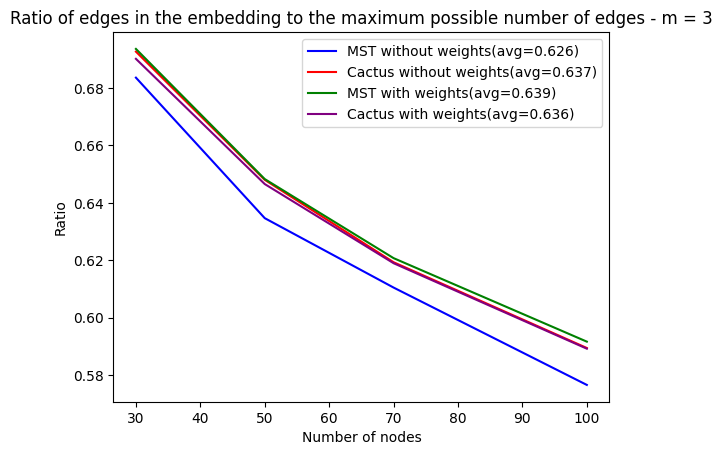

m = 4
n = 30
Iteration 0
Iteration 1
Iteration 2
Iteration 3
Iteration 4
Iteration 5
Iteration 6
Iteration 7
Iteration 8
Iteration 9
Iteration 10
Iteration 11
Iteration 12
Iteration 13
Iteration 14
Iteration 15
Iteration 16
Iteration 17
Iteration 18
Iteration 19
Iteration 20
Iteration 21
Iteration 22
Iteration 23
Iteration 24
Iteration 25
Iteration 26
Iteration 27
Iteration 28
Iteration 29
Iteration 30
Iteration 31
Iteration 32
Iteration 33
Iteration 34
Iteration 35
Iteration 36
Iteration 37
Iteration 38
Iteration 39
Iteration 40
Iteration 41
Iteration 42
Iteration 43
Iteration 44
Iteration 45
Iteration 46
Iteration 47
Iteration 48
Iteration 49
Iteration 50
Iteration 51
Iteration 52
Iteration 53
Iteration 54
Iteration 55
Iteration 56
Iteration 57
Iteration 58
Iteration 59
Iteration 60
Iteration 61
Iteration 62
Iteration 63
Iteration 64
Iteration 65
Iteration 66
Iteration 67
Iteration 68
Iteration 69
Iteration 70
Iteration 71
Iteration 72
Iteration 73
Iteration 74
Iteration 75
Iteration

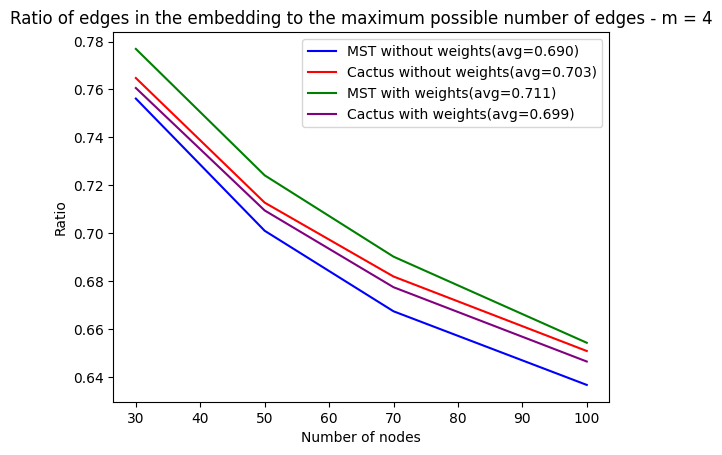

m = 5
n = 30
Iteration 0
Iteration 1
Iteration 2
Iteration 3
Iteration 4
Iteration 5
Iteration 6
Iteration 7
Iteration 8
Iteration 9
Iteration 10
Iteration 11
Iteration 12
Iteration 13
Iteration 14
Iteration 15
Iteration 16
Iteration 17
Iteration 18
Iteration 19
Iteration 20
Iteration 21
Iteration 22
Iteration 23
Iteration 24
Iteration 25
Iteration 26
Iteration 27
Iteration 28
Iteration 29
Iteration 30
Iteration 31
Iteration 32
Iteration 33
Iteration 34
Iteration 35
Iteration 36
Iteration 37
Iteration 38
Iteration 39
Iteration 40
Iteration 41
Iteration 42
Iteration 43
Iteration 44
Iteration 45
Iteration 46
Iteration 47
Iteration 48
Iteration 49
Iteration 50
Iteration 51
Iteration 52
Iteration 53
Iteration 54
Iteration 55
Iteration 56
Iteration 57
Iteration 58
Iteration 59
Iteration 60
Iteration 61
Iteration 62
Iteration 63
Iteration 64
Iteration 65
Iteration 66
Iteration 67
Iteration 68
Iteration 69
Iteration 70
Iteration 71
Iteration 72
Iteration 73
Iteration 74
Iteration 75
Iteration

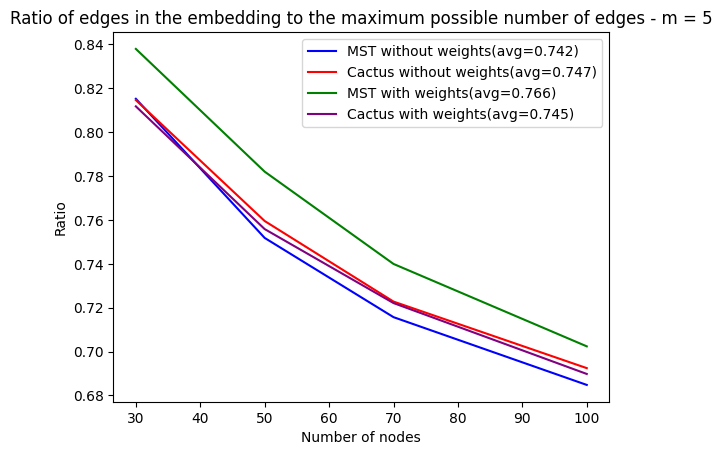

In [334]:
INITIAL_NODES = 5
TRIES = 100

for m in [2, 3, 4, 5]:
    print(f'm = {m}')
    n_value = []
    mst_ratios = []
    cactus_ratios = []
    mst_with_weights_ratios = []
    cactus_with_weights_ratios = []
    for n in [30, 50, 70, 100]:
        print(f'n = {n}')
        n_value.append(n)
        mst_sum = 0
        cactus_sum = 0
        mst_with_weights_sum = 0
        cactus_with_weights_sum = 0
        
        for _ in range(TRIES):
            print(f'Iteration {_}')

            graph = generate_graph_with_metric(INITIAL_NODES, n, m)

            mst_method = mst_embeddings_without_weights(graph.copy(), True)
            cactus_method = cactus_embeddings_without_weights(graph.copy(), True)
            mst_with_weights_method = mst_embeddings_with_weights(graph.copy(), True)
            cactus_with_weights_method = cactus_embeddings_with_weights(graph.copy(), True)

            mst_sum += get_ratio(graph, [len(m.edges()) for m in mst_method])[0]
            cactus_sum += get_ratio(graph, [len(m.edges()) for m in cactus_method])[0]
            mst_with_weights_sum += get_ratio(graph, [len(m.edges()) for m in mst_with_weights_method])[0]
            cactus_with_weights_sum += get_ratio(graph, [len(m.edges()) for m in cactus_with_weights_method])[0]

        mst_ratios.append(mst_sum / TRIES)
        cactus_ratios.append(cactus_sum / TRIES)
        mst_with_weights_ratios.append(mst_with_weights_sum / TRIES)
        cactus_with_weights_ratios.append(cactus_with_weights_sum / TRIES)

    plt.plot(n_value, mst_ratios, label=f'MST without weights(avg={sum(mst_ratios) / len(mst_ratios):.3f})', color='blue')
    plt.plot(n_value, cactus_ratios, label=f'Cactus without weights(avg={sum(cactus_ratios) / len(cactus_ratios):.3f})', color='red')
    plt.plot(n_value, mst_with_weights_ratios, label=f'MST with weights(avg={sum(mst_with_weights_ratios) / len(mst_with_weights_ratios):.3f})', color='green')
    plt.plot(n_value, cactus_with_weights_ratios, label=f'Cactus with weights(avg={sum(cactus_with_weights_ratios) / len(cactus_with_weights_ratios):.3f})', color='purple')

    plt.xlabel('Number of nodes')
    plt.ylabel('Ratio')
    plt.title(f'Ratio of edges in the embedding to the maximum possible number of edges - m = {m}')
    plt.legend()
    plt.show()


m = 5
n = 30
Iteration 0
Iteration 1
Iteration 2
Iteration 3
Iteration 4
Iteration 5
Iteration 6
Iteration 7
Iteration 8
Iteration 9
Iteration 10
Iteration 11
Iteration 12
Iteration 13
Iteration 14
Iteration 15
Iteration 16
Iteration 17
Iteration 18
Iteration 19
Iteration 20
Iteration 21
Iteration 22
Iteration 23
Iteration 24
Iteration 25
Iteration 26
Iteration 27
Iteration 28
Iteration 29
Iteration 30
Iteration 31
Iteration 32
Iteration 33
Iteration 34
Iteration 35
Iteration 36
Iteration 37
Iteration 38
Iteration 39
Iteration 40
Iteration 41
Iteration 42
Iteration 43
Iteration 44
Iteration 45
Iteration 46
Iteration 47
Iteration 48
Iteration 49
Iteration 50
Iteration 51
Iteration 52
Iteration 53
Iteration 54
Iteration 55
Iteration 56
Iteration 57
Iteration 58
Iteration 59
Iteration 60
Iteration 61
Iteration 62
Iteration 63
Iteration 64
Iteration 65
Iteration 66
Iteration 67
Iteration 68
Iteration 69
Iteration 70
Iteration 71
Iteration 72
Iteration 73
Iteration 74
Iteration 75
Iteration

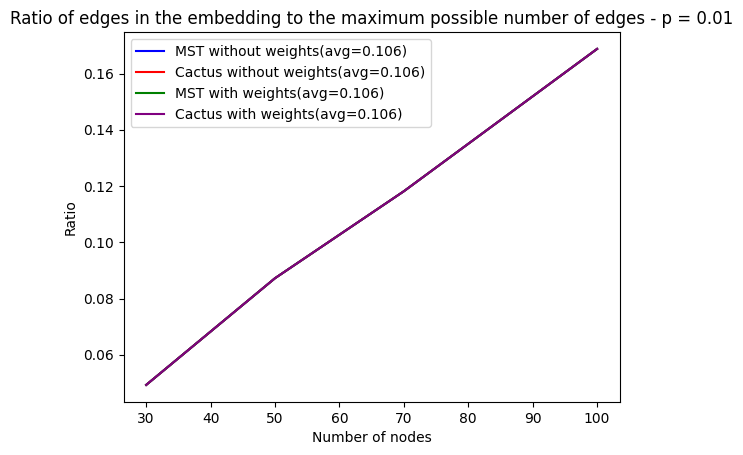

m = 5
n = 30
Iteration 0
Iteration 1
Iteration 2
Iteration 3
Iteration 4
Iteration 5
Iteration 6
Iteration 7
Iteration 8
Iteration 9
Iteration 10
Iteration 11
Iteration 12
Iteration 13
Iteration 14
Iteration 15
Iteration 16
Iteration 17
Iteration 18
Iteration 19
Iteration 20
Iteration 21
Iteration 22
Iteration 23
Iteration 24
Iteration 25
Iteration 26
Iteration 27
Iteration 28
Iteration 29
Iteration 30
Iteration 31
Iteration 32
Iteration 33
Iteration 34
Iteration 35
Iteration 36
Iteration 37
Iteration 38
Iteration 39
Iteration 40
Iteration 41
Iteration 42
Iteration 43
Iteration 44
Iteration 45
Iteration 46
Iteration 47
Iteration 48
Iteration 49
Iteration 50
Iteration 51
Iteration 52
Iteration 53
Iteration 54
Iteration 55
Iteration 56
Iteration 57
Iteration 58
Iteration 59
Iteration 60
Iteration 61
Iteration 62
Iteration 63
Iteration 64
Iteration 65
Iteration 66
Iteration 67
Iteration 68
Iteration 69
Iteration 70
Iteration 71
Iteration 72
Iteration 73
Iteration 74
Iteration 75
Iteration

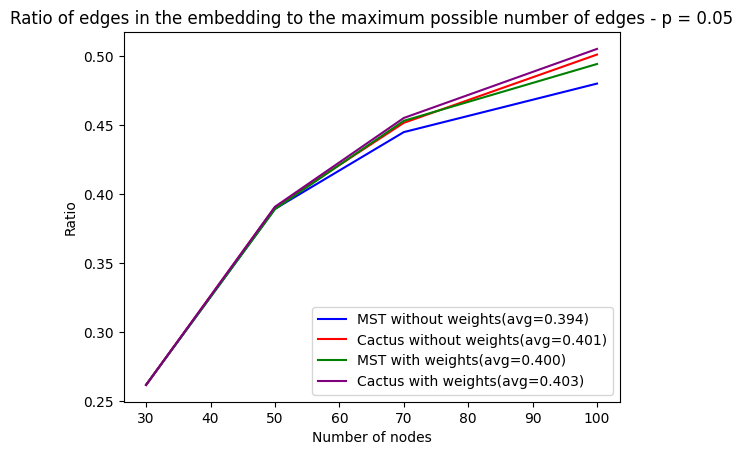

m = 5
n = 30
Iteration 0
Iteration 1
Iteration 2
Iteration 3
Iteration 4
Iteration 5
Iteration 6
Iteration 7
Iteration 8
Iteration 9
Iteration 10
Iteration 11
Iteration 12
Iteration 13
Iteration 14
Iteration 15
Iteration 16
Iteration 17
Iteration 18
Iteration 19
Iteration 20
Iteration 21
Iteration 22
Iteration 23
Iteration 24
Iteration 25
Iteration 26
Iteration 27
Iteration 28
Iteration 29
Iteration 30
Iteration 31
Iteration 32
Iteration 33
Iteration 34
Iteration 35
Iteration 36
Iteration 37
Iteration 38
Iteration 39
Iteration 40
Iteration 41
Iteration 42
Iteration 43
Iteration 44
Iteration 45
Iteration 46
Iteration 47
Iteration 48
Iteration 49
Iteration 50
Iteration 51
Iteration 52
Iteration 53
Iteration 54
Iteration 55
Iteration 56
Iteration 57
Iteration 58
Iteration 59
Iteration 60
Iteration 61
Iteration 62
Iteration 63
Iteration 64
Iteration 65
Iteration 66
Iteration 67
Iteration 68
Iteration 69
Iteration 70
Iteration 71
Iteration 72
Iteration 73
Iteration 74
Iteration 75
Iteration

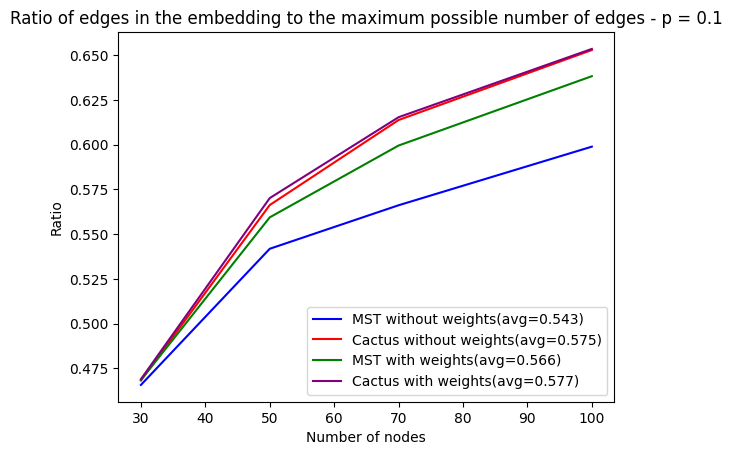

m = 5
n = 30
Iteration 0
Iteration 1
Iteration 2
Iteration 3
Iteration 4
Iteration 5
Iteration 6
Iteration 7
Iteration 8
Iteration 9
Iteration 10
Iteration 11
Iteration 12
Iteration 13
Iteration 14
Iteration 15
Iteration 16
Iteration 17
Iteration 18
Iteration 19
Iteration 20
Iteration 21
Iteration 22
Iteration 23
Iteration 24
Iteration 25
Iteration 26
Iteration 27
Iteration 28
Iteration 29
Iteration 30
Iteration 31
Iteration 32
Iteration 33
Iteration 34
Iteration 35
Iteration 36
Iteration 37
Iteration 38
Iteration 39
Iteration 40
Iteration 41
Iteration 42
Iteration 43
Iteration 44
Iteration 45
Iteration 46
Iteration 47
Iteration 48
Iteration 49
Iteration 50
Iteration 51
Iteration 52
Iteration 53
Iteration 54
Iteration 55
Iteration 56
Iteration 57
Iteration 58
Iteration 59
Iteration 60
Iteration 61
Iteration 62
Iteration 63
Iteration 64
Iteration 65
Iteration 66
Iteration 67
Iteration 68
Iteration 69
Iteration 70
Iteration 71
Iteration 72
Iteration 73
Iteration 74
Iteration 75
Iteration

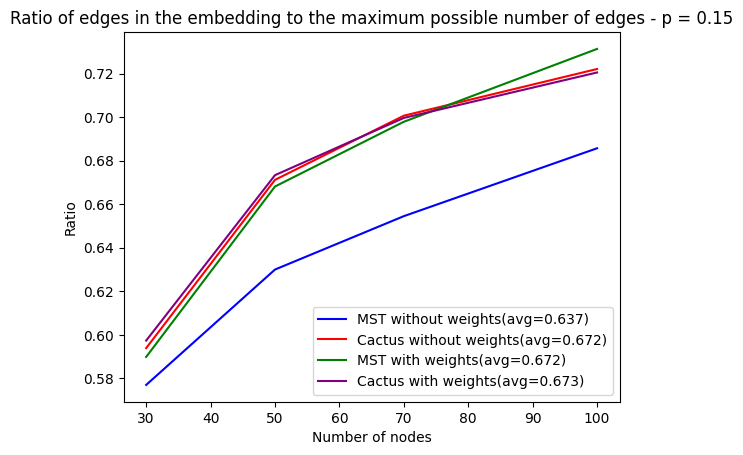

In [335]:
TRIES = 100

mst_ratios = []
mst_with_weights_ratios = []

for p in [0.01, 0.05, 0.1, 0.15]:
    print(f'm = {m}')
    n_value = []
    mst_ratios = []
    cactus_ratios = []
    mst_with_weights_ratios = []
    cacuts_with_weights_ratios = []
    for n in [30, 50, 70, 100]:
        print(f'n = {n}')
        n_value.append(n)
        mst_sum = 0
        cactus_sum = 0
        mst_with_weights_sum = 0
        cacuts_with_weights_sum = 0
        for _ in range(TRIES):
            print(f'Iteration {_}')

            graph = nx.gnp_random_graph(n, p)

            mst_method = mst_embeddings_without_weights(graph.copy(), True)
            cactus_method = cactus_embeddings_without_weights(graph.copy(), True)
            mst_with_weights_method = mst_embeddings_with_weights(graph.copy(), True)
            cacuts_with_weights_method = cactus_embeddings_with_weights(graph.copy(), True)

            mst_sum += get_ratio(graph, [len(m.edges()) for m in mst_method])[0]
            cactus_sum += get_ratio(graph, [len(m.edges()) for m in cactus_method])[0]
            mst_with_weights_sum += get_ratio(graph, [len(m.edges()) for m in mst_with_weights_method])[0]
            cacuts_with_weights_sum += get_ratio(graph, [len(m.edges()) for m in cacuts_with_weights_method])[0]

        mst_ratios.append(mst_sum / TRIES)
        cactus_ratios.append(cactus_sum / TRIES)
        mst_with_weights_ratios.append(mst_with_weights_sum / TRIES)
        cacuts_with_weights_ratios.append(cacuts_with_weights_sum / TRIES)

    plt.plot(n_value, mst_ratios, label=f'MST without weights(avg={sum(mst_ratios) / len(mst_ratios):.3f})', color='blue')
    plt.plot(n_value, cactus_ratios, label=f'Cactus without weights(avg={sum(cactus_ratios) / len(cactus_ratios):.3f})', color='red')
    plt.plot(n_value, mst_with_weights_ratios, label=f'MST with weights(avg={sum(mst_with_weights_ratios) / len(mst_with_weights_ratios):.3f})', color='green')
    plt.plot(n_value, cacuts_with_weights_ratios, label=f'Cactus with weights(avg={sum(cacuts_with_weights_ratios) / len(cacuts_with_weights_ratios):.3f})', color='purple')

    plt.xlabel('Number of nodes')
    plt.ylabel('Ratio')
    plt.title(f'Ratio of edges in the embedding to the maximum possible number of edges - p = {p}')
    plt.legend()
    plt.show()

m = 2
n = 30
Iteration 0
Iteration 1
Iteration 2
Iteration 3
Iteration 4
Iteration 5
Iteration 6
Iteration 7
Iteration 8
Iteration 9
Iteration 10
Iteration 11
Iteration 12
Iteration 13
Iteration 14
Iteration 15
Iteration 16
Iteration 17
Iteration 18
Iteration 19
Iteration 20
Iteration 21
Iteration 22
Iteration 23
Iteration 24
Iteration 25
Iteration 26
Iteration 27
Iteration 28
Iteration 29
Iteration 30
Iteration 31
Iteration 32
Iteration 33
Iteration 34
Iteration 35
Iteration 36
Iteration 37
Iteration 38
Iteration 39
Iteration 40
Iteration 41
Iteration 42
Iteration 43
Iteration 44
Iteration 45
Iteration 46
Iteration 47
Iteration 48
Iteration 49
n = 50
Iteration 0
Iteration 1
Iteration 2
Iteration 3
Iteration 4
Iteration 5
Iteration 6
Iteration 7
Iteration 8
Iteration 9
Iteration 10
Iteration 11
Iteration 12
Iteration 13
Iteration 14
Iteration 15
Iteration 16
Iteration 17
Iteration 18
Iteration 19
Iteration 20
Iteration 21
Iteration 22
Iteration 23
Iteration 24
Iteration 25
Iteration 26

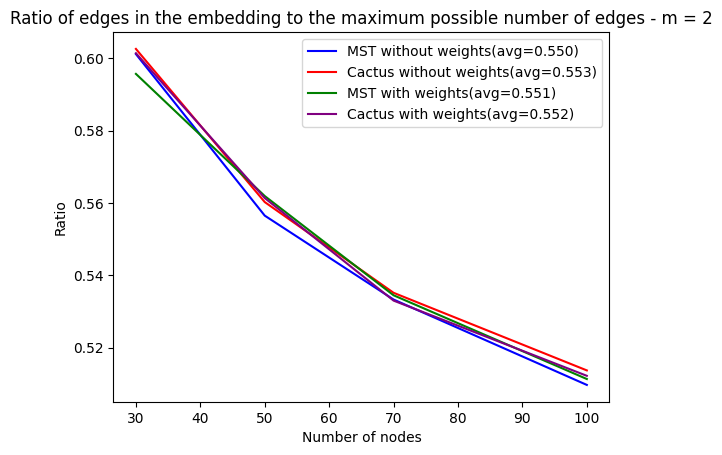

m = 3
n = 30
Iteration 0
Iteration 1
Iteration 2
Iteration 3
Iteration 4
Iteration 5
Iteration 6
Iteration 7
Iteration 8
Iteration 9
Iteration 10
Iteration 11
Iteration 12
Iteration 13
Iteration 14
Iteration 15
Iteration 16
Iteration 17
Iteration 18
Iteration 19
Iteration 20
Iteration 21
Iteration 22
Iteration 23
Iteration 24
Iteration 25
Iteration 26
Iteration 27
Iteration 28
Iteration 29
Iteration 30
Iteration 31
Iteration 32
Iteration 33
Iteration 34
Iteration 35
Iteration 36
Iteration 37
Iteration 38
Iteration 39
Iteration 40
Iteration 41
Iteration 42
Iteration 43
Iteration 44
Iteration 45
Iteration 46
Iteration 47
Iteration 48
Iteration 49
n = 50
Iteration 0
Iteration 1
Iteration 2
Iteration 3
Iteration 4
Iteration 5
Iteration 6
Iteration 7
Iteration 8
Iteration 9
Iteration 10
Iteration 11
Iteration 12
Iteration 13
Iteration 14
Iteration 15
Iteration 16
Iteration 17
Iteration 18
Iteration 19
Iteration 20
Iteration 21
Iteration 22
Iteration 23
Iteration 24
Iteration 25
Iteration 26

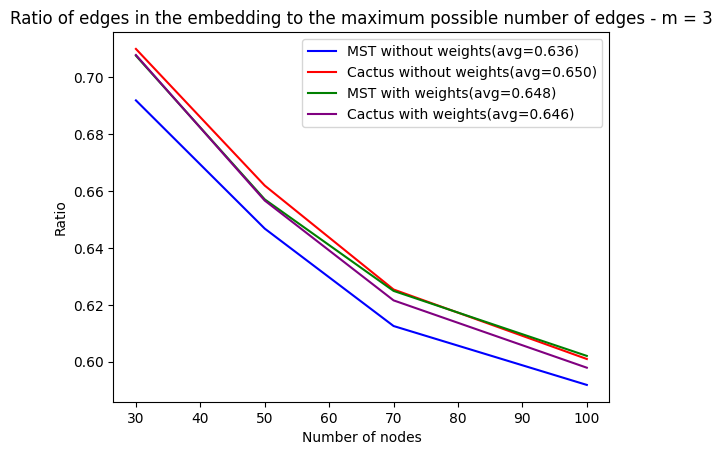

m = 4
n = 30
Iteration 0
Iteration 1
Iteration 2
Iteration 3
Iteration 4
Iteration 5
Iteration 6
Iteration 7
Iteration 8
Iteration 9
Iteration 10
Iteration 11
Iteration 12
Iteration 13
Iteration 14
Iteration 15
Iteration 16
Iteration 17
Iteration 18
Iteration 19
Iteration 20
Iteration 21
Iteration 22
Iteration 23
Iteration 24
Iteration 25
Iteration 26
Iteration 27
Iteration 28
Iteration 29
Iteration 30
Iteration 31
Iteration 32
Iteration 33
Iteration 34
Iteration 35
Iteration 36
Iteration 37
Iteration 38
Iteration 39
Iteration 40
Iteration 41
Iteration 42
Iteration 43
Iteration 44
Iteration 45
Iteration 46
Iteration 47
Iteration 48
Iteration 49
n = 50
Iteration 0
Iteration 1
Iteration 2
Iteration 3
Iteration 4
Iteration 5
Iteration 6
Iteration 7
Iteration 8
Iteration 9
Iteration 10
Iteration 11
Iteration 12
Iteration 13
Iteration 14
Iteration 15
Iteration 16
Iteration 17
Iteration 18
Iteration 19
Iteration 20
Iteration 21
Iteration 22
Iteration 23
Iteration 24
Iteration 25
Iteration 26

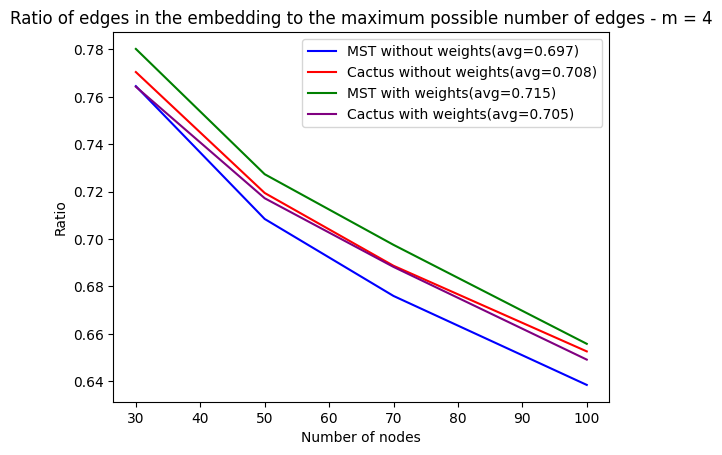

m = 5
n = 30
Iteration 0
Iteration 1
Iteration 2
Iteration 3
Iteration 4
Iteration 5
Iteration 6
Iteration 7
Iteration 8
Iteration 9
Iteration 10
Iteration 11
Iteration 12
Iteration 13
Iteration 14
Iteration 15
Iteration 16
Iteration 17
Iteration 18
Iteration 19
Iteration 20
Iteration 21
Iteration 22
Iteration 23
Iteration 24
Iteration 25
Iteration 26
Iteration 27
Iteration 28
Iteration 29
Iteration 30
Iteration 31
Iteration 32
Iteration 33
Iteration 34
Iteration 35
Iteration 36
Iteration 37
Iteration 38
Iteration 39
Iteration 40
Iteration 41
Iteration 42
Iteration 43
Iteration 44
Iteration 45
Iteration 46
Iteration 47
Iteration 48
Iteration 49
n = 50
Iteration 0
Iteration 1
Iteration 2
Iteration 3
Iteration 4
Iteration 5
Iteration 6
Iteration 7
Iteration 8
Iteration 9
Iteration 10
Iteration 11
Iteration 12
Iteration 13
Iteration 14
Iteration 15
Iteration 16
Iteration 17
Iteration 18
Iteration 19
Iteration 20
Iteration 21
Iteration 22
Iteration 23
Iteration 24
Iteration 25
Iteration 26

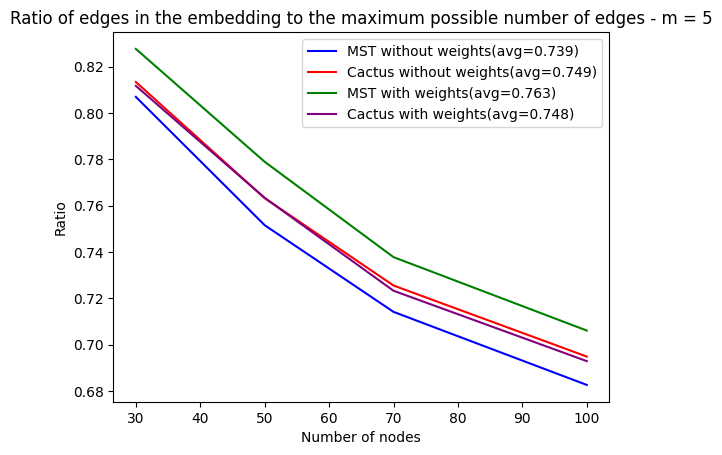

In [338]:
TRIES = 50

mst_ratios = []
mst_with_weights_ratios = []

for m in [2, 3, 4, 5]:
    print(f'm = {m}')
    n_value = []
    mst_ratios = []
    cactus_ratios = []
    mst_with_weights_ratios = []
    cacuts_with_weights_ratios = []
    for n in [30, 50, 70, 100]:
        print(f'n = {n}')
        n_value.append(n)
        mst_sum = 0
        cactus_sum = 0
        mst_with_weights_sum = 0
        cacuts_with_weights_sum = 0
        for _ in range(TRIES):
            print(f'Iteration {_}')

            graph = nx.barabasi_albert_graph(n, m)

            mst_method = mst_embeddings_without_weights(graph.copy(), True)
            cactus_method = cactus_embeddings_without_weights(graph.copy(), True)
            mst_with_weights_method = mst_embeddings_with_weights(graph.copy(), True)
            cacuts_with_weights_method = cactus_embeddings_with_weights(graph.copy(), True)

            mst_sum += get_ratio(graph, [len(m.edges()) for m in mst_method])[0]
            cactus_sum += get_ratio(graph, [len(m.edges()) for m in cactus_method])[0]
            mst_with_weights_sum += get_ratio(graph, [len(m.edges()) for m in mst_with_weights_method])[0]
            cacuts_with_weights_sum += get_ratio(graph, [len(m.edges()) for m in cacuts_with_weights_method])[0]

        mst_ratios.append(mst_sum / TRIES)
        cactus_ratios.append(cactus_sum / TRIES)
        mst_with_weights_ratios.append(mst_with_weights_sum / TRIES)
        cacuts_with_weights_ratios.append(cacuts_with_weights_sum / TRIES)

    plt.plot(n_value, mst_ratios, label=f'MST without weights(avg={sum(mst_ratios) / len(mst_ratios):.3f})', color='blue')
    plt.plot(n_value, cactus_ratios, label=f'Cactus without weights(avg={sum(cactus_ratios) / len(cactus_ratios):.3f})', color='red')
    plt.plot(n_value, mst_with_weights_ratios, label=f'MST with weights(avg={sum(mst_with_weights_ratios) / len(mst_with_weights_ratios):.3f})', color='green')
    plt.plot(n_value, cacuts_with_weights_ratios, label=f'Cactus with weights(avg={sum(cacuts_with_weights_ratios) / len(cacuts_with_weights_ratios):.3f})', color='purple')

    plt.xlabel('Number of nodes')
    plt.ylabel('Ratio')
    plt.title(f'Ratio of edges in the embedding to the maximum possible number of edges - m = {m}')
    plt.legend()
    plt.show()

In [98]:
def compare(initial_nodes, final_nodes, edges_per_node, with_complement, tries):
    mst_ratios = []
    mst_emmbeddings_number = []
    mst_with_weights_ratios = []
    mst_with_weights_emmbeddings_number = []
    cactus_ratios = []
    cactus_embeddings_number = []
    cactus_with_weights_ratios = []
    cactus_with_weights_embeddings_number = []

    for _ in range(tries):
        graph = generate_graph_with_metric(initial_nodes, final_nodes, edges_per_node)
        mst_method = mst_embeddings_without_weights(graph.copy(), with_complement)
        mst_with_weights_method = mst_embeddings_with_weights(graph.copy(), with_complement)

        cactus_method = cactus_embeddings_without_weights(graph.copy(), with_complement)
        cactus_with_weights_method = cactus_embeddings_with_weights(graph.copy(), with_complement)

        mst_ratios.append(get_ratio(graph, [len(m.edges()) for m in mst_method]))
        mst_emmbeddings_number.append(len(mst_method))
        mst_with_weights_ratios.append(get_ratio(graph, [len(m.edges()) for m in mst_with_weights_method]))
        mst_with_weights_emmbeddings_number.append(len(mst_with_weights_method))
        cactus_ratios.append(get_ratio(graph, [len(m.edges()) for m in cactus_method]))
        cactus_embeddings_number.append(len(cactus_method))
        cactus_with_weights_ratios.append(get_ratio(graph, [len(m.edges()) for m in cactus_with_weights_method]))
        cactus_with_weights_embeddings_number.append(len(cactus_with_weights_method))

    return mst_ratios, mst_emmbeddings_number, mst_with_weights_ratios, mst_with_weights_emmbeddings_number, cactus_ratios, cactus_embeddings_number, cactus_with_weights_ratios, cactus_with_weights_embeddings_number

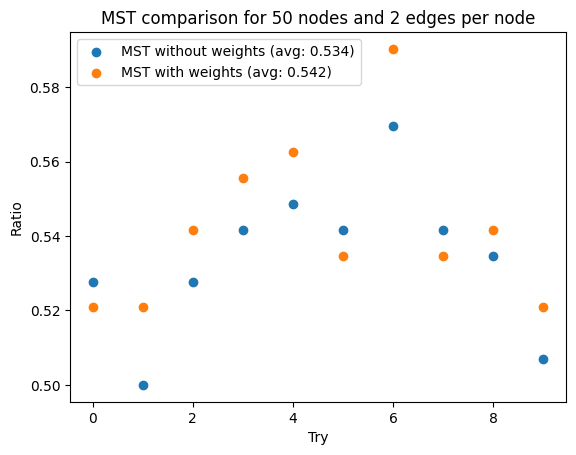

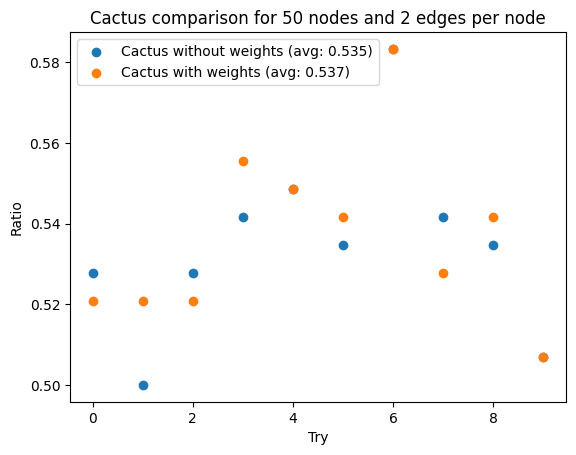

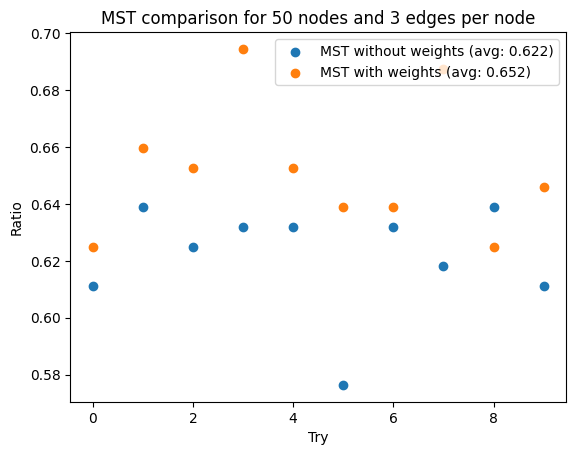

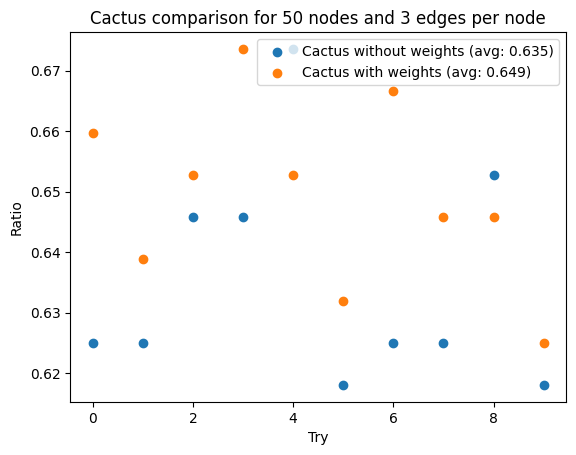

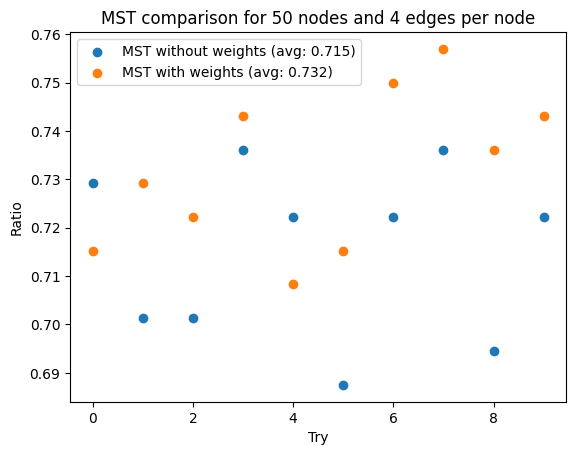

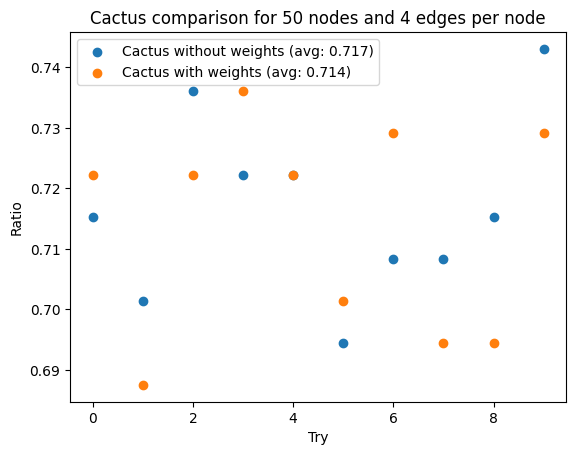

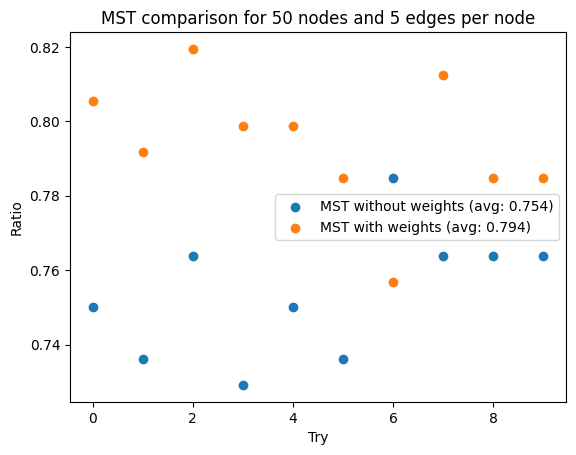

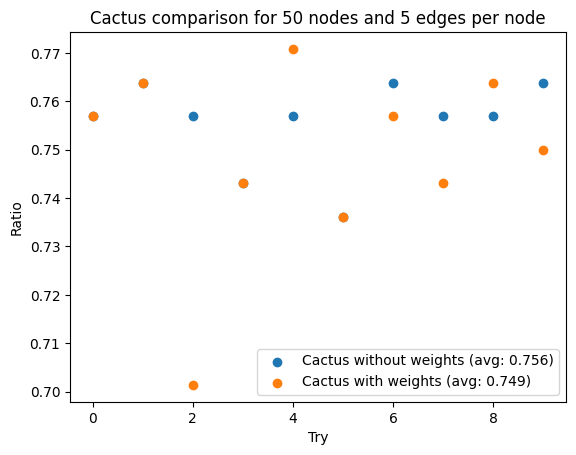

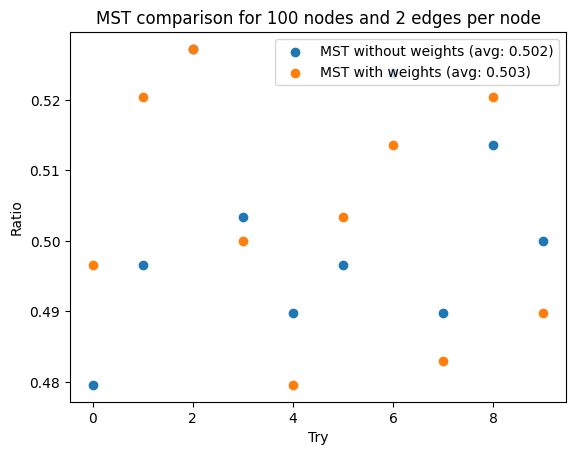

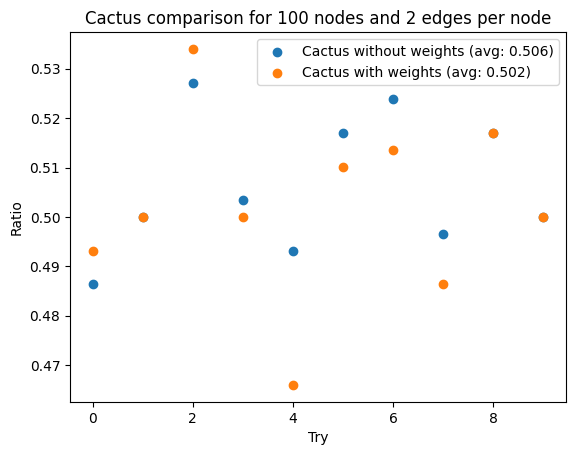

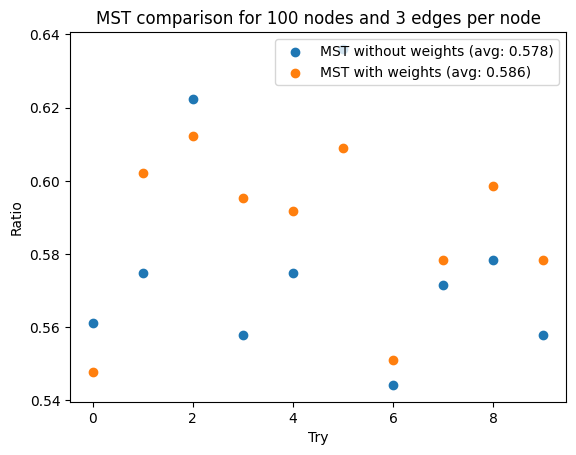

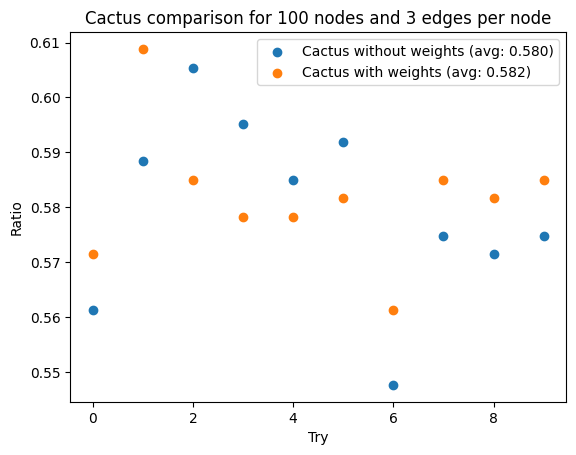

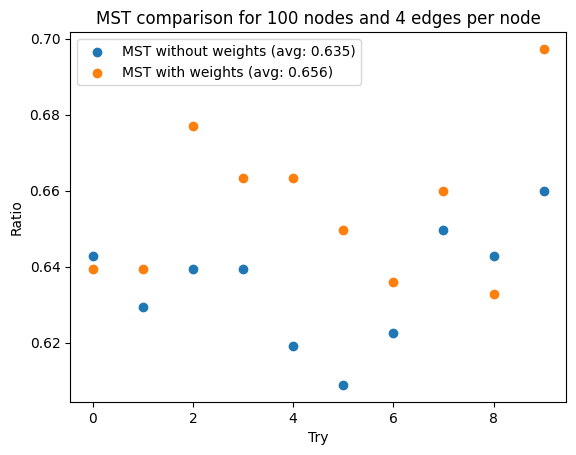

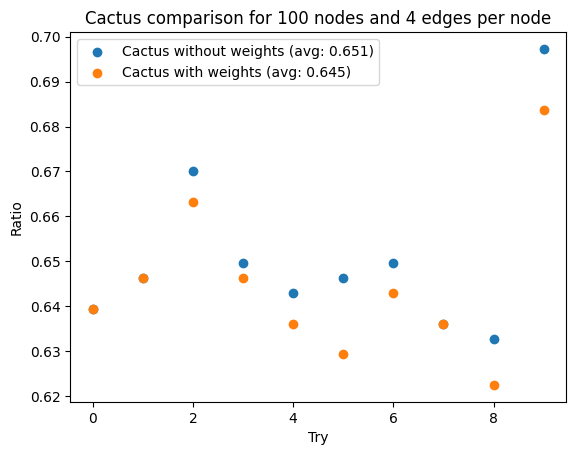

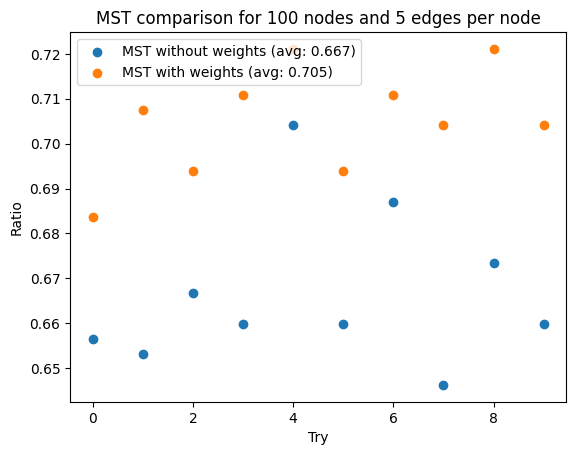

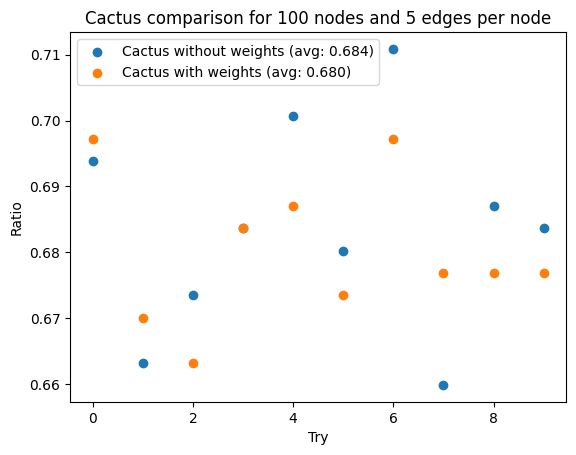

In [99]:
TRIES = 10

for initial_nodes in [5]:
    for final_nodes in [50, 100]:
        for edges_per_node in [2, 3, 4, 5]:
            mst_ratios, mst_emmbeddings_number, mst_with_weights_ratios, mst_with_weights_emmbeddings_number, cactus_ratios, cactus_embeddings_number, cactus_with_weights_ratios, cactus_with_weights_embeddings_number = compare(initial_nodes, final_nodes, edges_per_node, True, TRIES)

            avg_mst_ratio = np.mean([ratio[0] for ratio in mst_ratios])
            avg_mst_with_weights_ratio = np.mean([ratio[0] for ratio in mst_with_weights_ratios])

            avg_mst_emmbbeddings_number = np.mean(mst_emmbeddings_number)
            avg_mst_with_weights_emmbeddings_number = np.mean(mst_with_weights_emmbeddings_number)

            avg_cactus_ratio = np.mean([ratio[0] for ratio in cactus_ratios])
            avg_cactus_with_weights_ratio = np.mean([ratio[0] for ratio in cactus_with_weights_ratios])

            avg_cactus_embeddings_number = np.mean(cactus_embeddings_number)
            avg_cactus_with_weights_embeddings_number = np.mean(cactus_with_weights_embeddings_number)

            tries = [i for i in range(TRIES)]

            plt.scatter(tries, [ratio[0] for ratio in mst_ratios], label='MST without weights (avg: {:.3f})'.format(avg_mst_ratio))
            plt.scatter(tries, [ratio[0] for ratio in mst_with_weights_ratios], label='MST with weights (avg: {:.3f})'.format(avg_mst_with_weights_ratio))
            plt.title(f'MST comparison for {final_nodes} nodes and {edges_per_node} edges per node')
            plt.xlabel('Try')
            plt.ylabel('Ratio')
            plt.legend()
            plt.show()

            plt.scatter(tries, [ratio[0] for ratio in cactus_ratios], label='Cactus without weights (avg: {:.3f})'.format(avg_cactus_ratio))
            plt.scatter(tries, [ratio[0] for ratio in cactus_with_weights_ratios], label='Cactus with weights (avg: {:.3f})'.format(avg_cactus_with_weights_ratio))
            plt.title(f'Cactus comparison for {final_nodes} nodes and {edges_per_node} edges per node')
            plt.xlabel('Try')
            plt.ylabel('Ratio')
            plt.legend()
            plt.show()

In [ ]:
TRIES = 10

for initial_nodes in [5]:
    for final_nodes in [50, 100]:
        for edges_per_node in [2, 3, 4]:
            mst_ratios, mst_emmbeddings_number, mst_with_weights_ratios, mst_with_weights_emmbeddings_number, cactus_ratios, cactus_embeddings_number, cactus_with_weights_ratios, cactus_with_weights_embeddings_number = compare(initial_nodes, final_nodes, edges_per_node, False, TRIES)

            avg_mst_ratio = np.mean([ratio[0] for ratio in mst_ratios])
            avg_mst_with_weights_ratio = np.mean([ratio[0] for ratio in mst_with_weights_ratios])

            avg_mst_emmbbeddings_number = np.mean(mst_emmbeddings_number)
            avg_mst_with_weights_emmbeddings_number = np.mean(mst_with_weights_emmbeddings_number)

            avg_cactus_ratio = np.mean([ratio[0] for ratio in cactus_ratios])
            avg_cactus_with_weights_ratio = np.mean([ratio[0] for ratio in cactus_with_weights_ratios])

            avg_cactus_embeddings_number = np.mean(cactus_embeddings_number)
            avg_cactus_with_weights_embeddings_number = np.mean(cactus_with_weights_embeddings_number)

            tries = [i for i in range(TRIES)]

            plt.scatter(tries, mst_emmbeddings_number, label='MST without weights (avg: {:.3f})'.format(avg_mst_emmbbeddings_number))
            plt.scatter(tries, mst_with_weights_emmbeddings_number, label='MST with weights (avg: {:.3f})'.format(avg_mst_with_weights_emmbeddings_number))
            plt.title(f'MST embeddings number comparison for {final_nodes} nodes and {edges_per_node} edges per node')
            plt.xlabel('Try')
            plt.ylabel('Embeddings number')
            plt.legend()
            plt.show()

            plt.scatter(tries, cactus_embeddings_number, label='Cactus without weights (avg: {:.3f})'.format(avg_cactus_embeddings_number))
            plt.scatter(tries, cactus_with_weights_embeddings_number, label='Cactus with weights (avg: {:.3f})'.format(avg_cactus_with_weights_embeddings_number))
            plt.title(f'Cactus embeddings number comparison for {final_nodes} nodes and {edges_per_node} edges per node')
            plt.xlabel('Try')
            plt.ylabel('Embeddings number')
            plt.legend()
            plt.show()

In [125]:
TRIES = 10
INITIAL_NODES = 3
FINAL_NODES = 17
EDGES_PER_NODE = 3

results = []
for t in range(TRIES):
    print(f'Try {t + 1}')

    graph = generate_graph(INITIAL_NODES, FINAL_NODES, EDGES_PER_NODE)
    
    paths_number_for_degrees = {}
    for node in graph.nodes():
        paths_number_for_degrees[graph.degree(node)] = 0

    edge_usage_number = {}
    for edge in graph.edges():
        if edge[0] < edge[1]:
            edge_usage_number[edge] = 0
        else:
            edge_usage_number[(edge[1], edge[0])] = 0

    for source in graph.nodes():
        for target in graph.nodes():
            if source != target:
                try:
                    paths = list(nx.all_simple_paths(graph, source, target, 10))
                    paths_number_for_degrees[graph.degree(source)] += len(paths)
                    for path in paths:
                        for i in range(len(path) - 1):
                            if path[i] < path[i+1]:
                                edge_usage_number[(path[i], path[i+1])] += 1
                            else:
                                edge_usage_number[(path[i+1], path[i])] += 1

                except nx.NetworkXNoPath:
                    pass

    results.append((graph, paths_number_for_degrees, edge_usage_number))

pickle.dump(results, open(f'calculation-cache/results_{INITIAL_NODES}_{EDGES_PER_NODE}_{FINAL_NODES}_bound10.pkl', 'wb'))

Try 1
Try 2
Try 3
Try 4
Try 5
Try 6
Try 7
Try 8
Try 9
Try 10


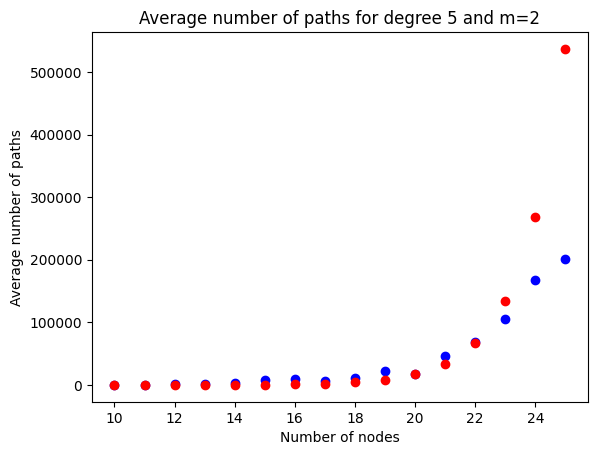

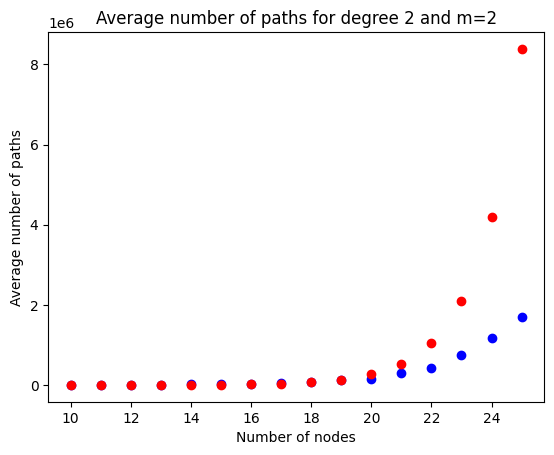

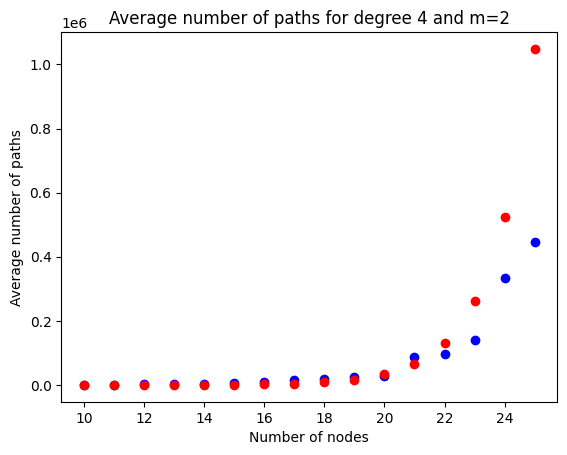

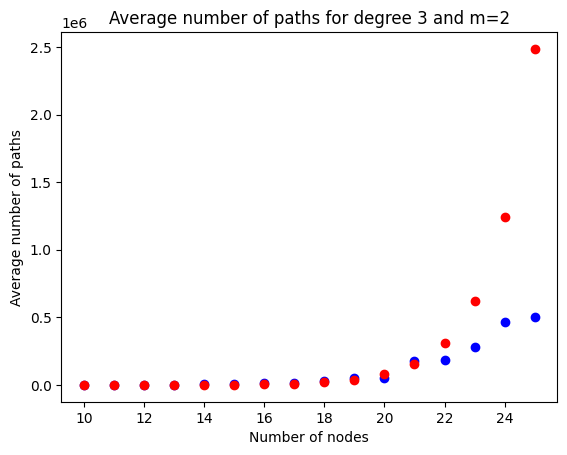

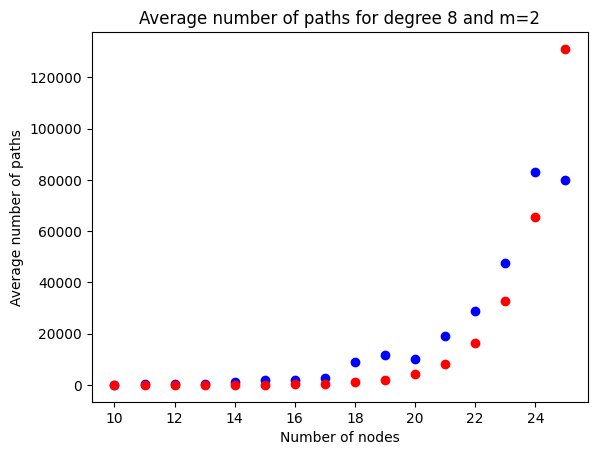

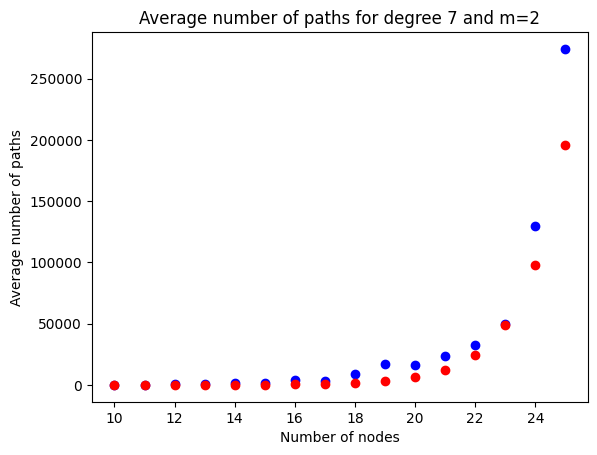

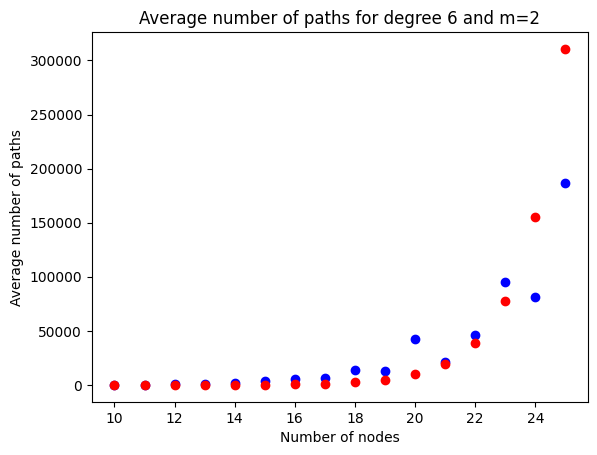

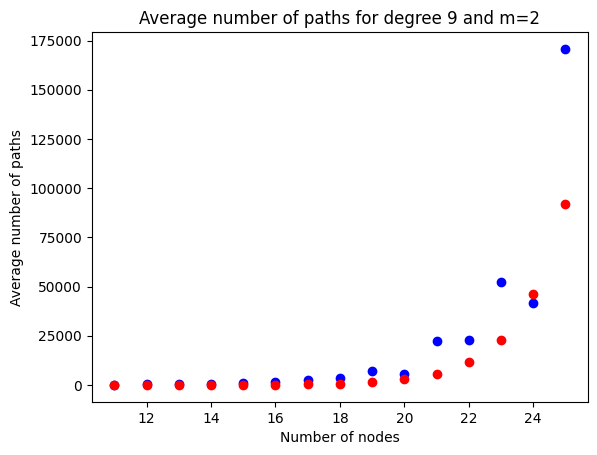

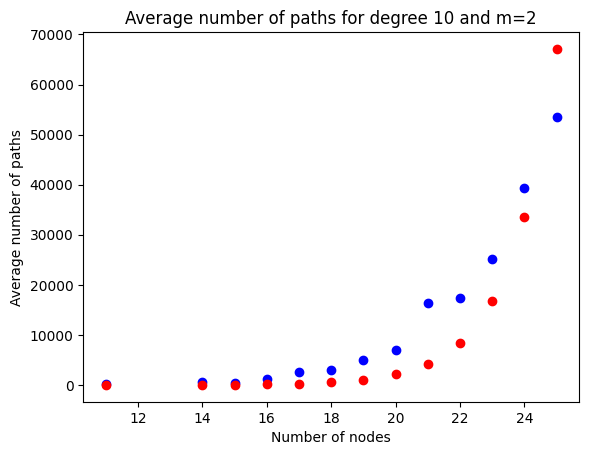

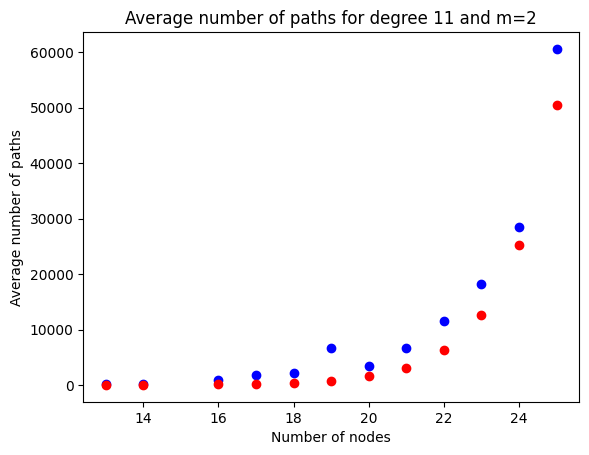

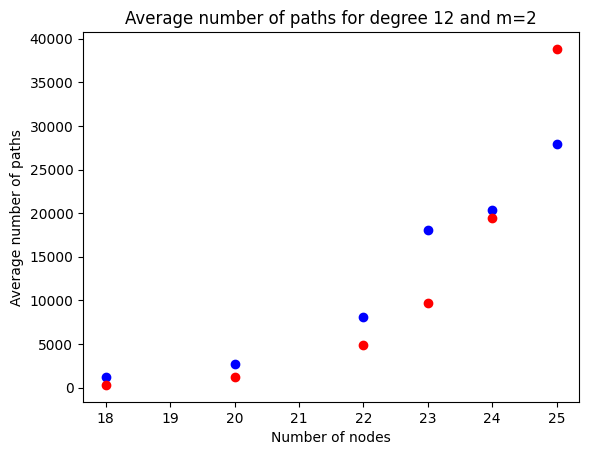

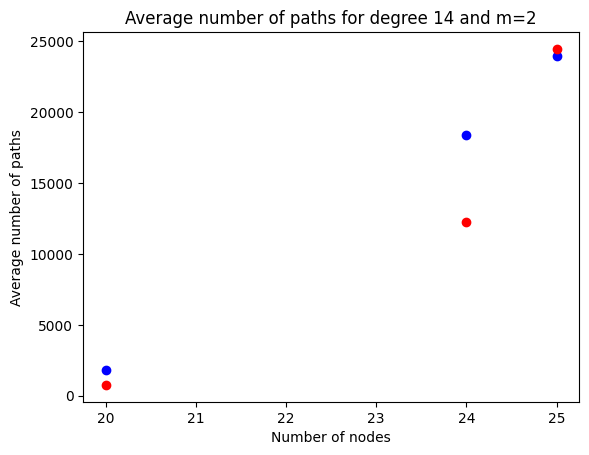

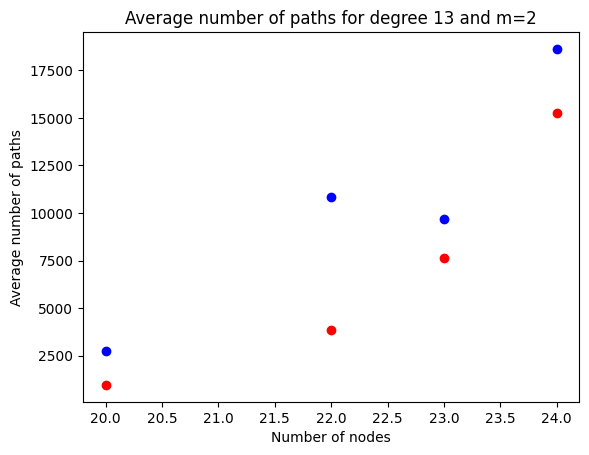

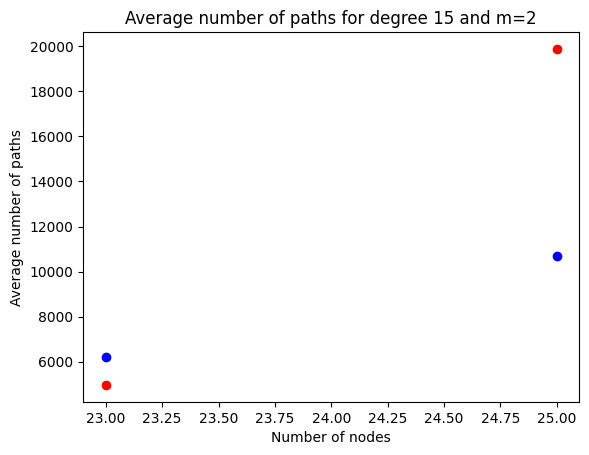

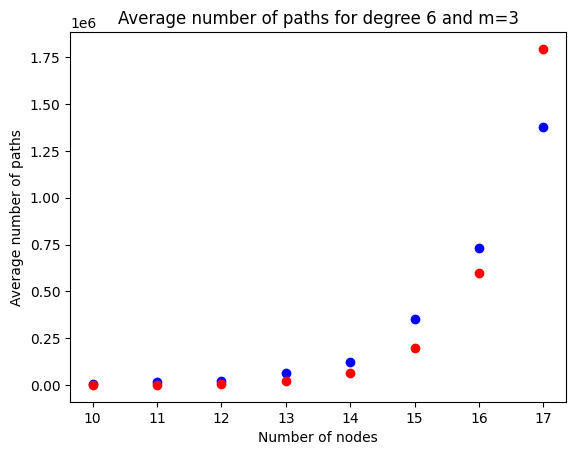

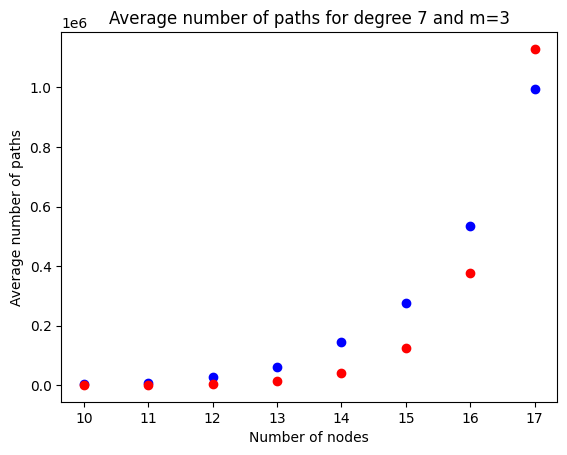

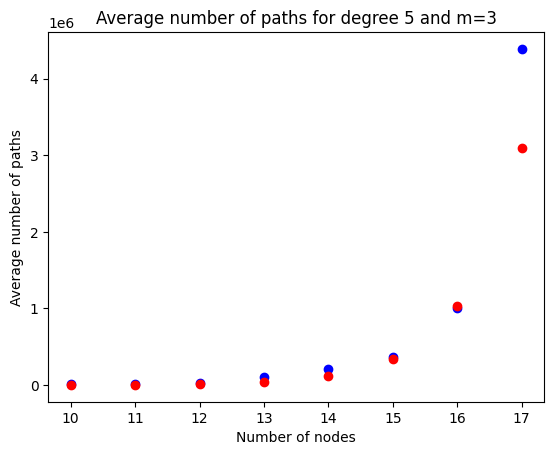

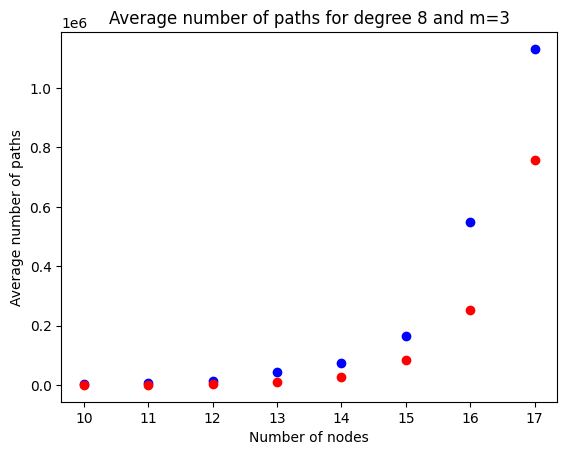

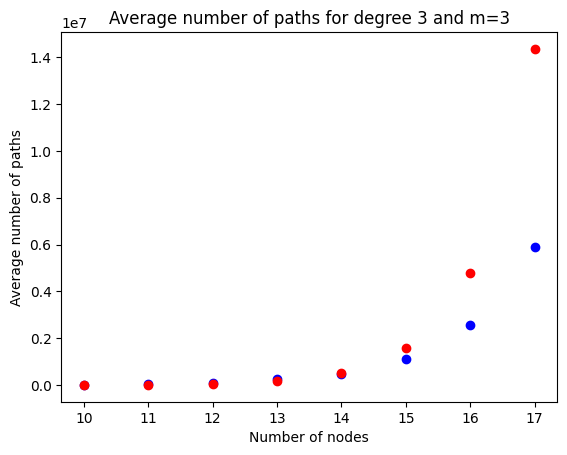

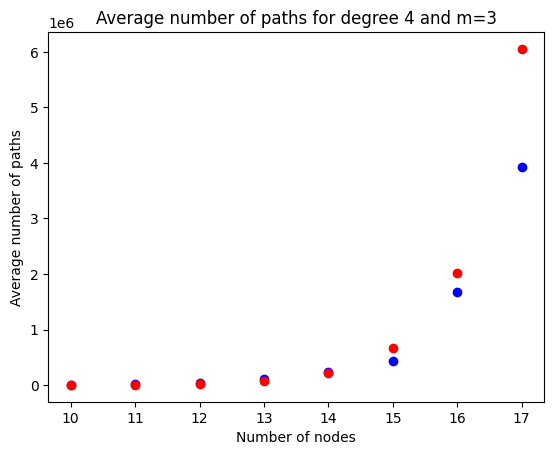

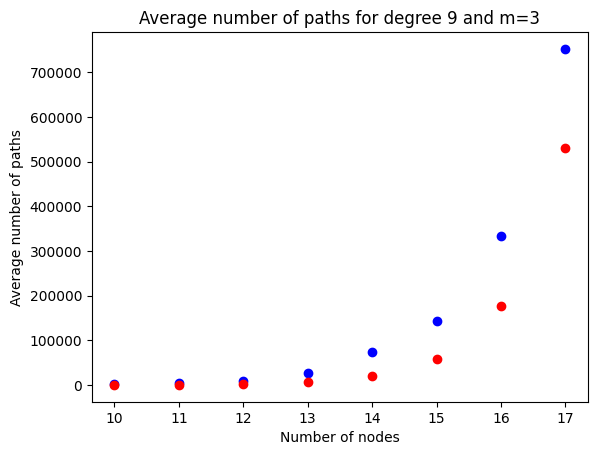

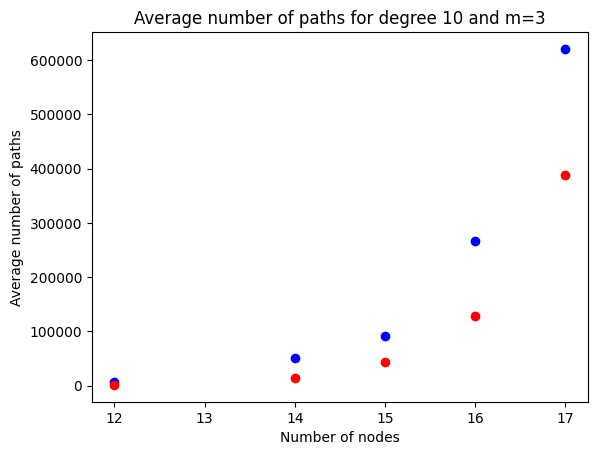

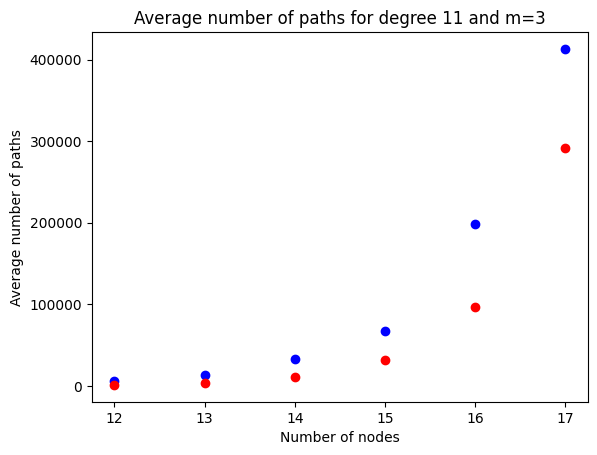

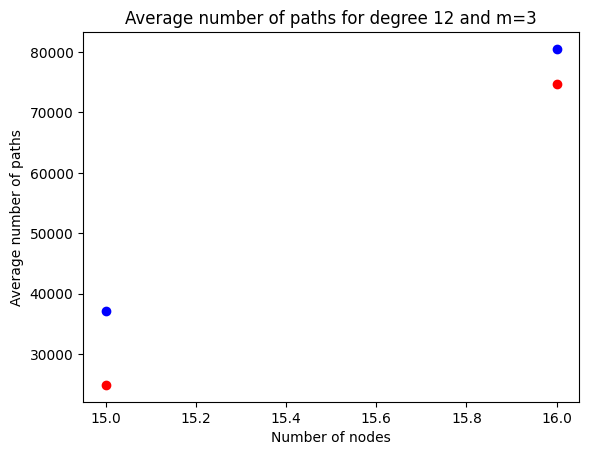

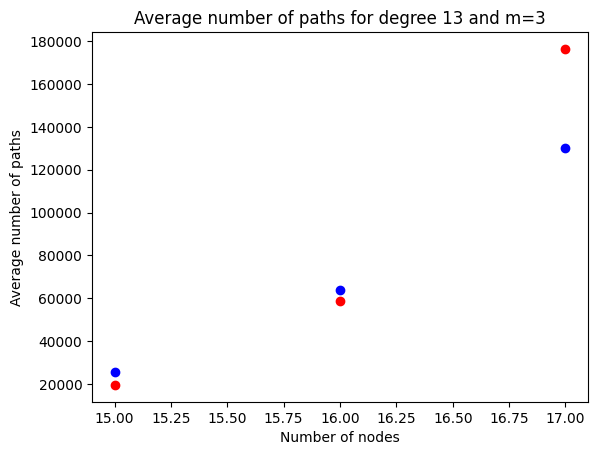

In [157]:
input_data = {
    2: [10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25],
    3: [10, 11, 12, 13, 14, 15, 16, 17]
}

for m, ns in input_data.items():
    data = {}
    for n in ns:
        results = pickle.load(open(f'calculation-cache/results_{3}_{m}_{n}.pkl', 'rb'))
        
        deg_paths = {}
        for result in results:
            for deg, paths_num in result[1].items():
                if deg not in deg_paths:
                    deg_paths[deg] = []
                deg_paths[deg].append(paths_num)

        degs = []
        avg_paths_num = []
        for deg, paths_num in deg_paths.items():
            degs.append(deg)
            avg_paths_num.append(sum(paths_num) / len(paths_num))

        for deg, avg in zip(degs, avg_paths_num):
            if deg not in data:
                data[deg] = {}
            data[deg][n] = avg

    def get_n(d, n, m):
        return (d ** -3) * (m ** (n+1))
    
    def logm(val, m):
        return math.log(val) / math.log(m)

    def coeff_p(val, d, n, m):
        return logm(val / (d ** -3), m) / n

    for d in data:
        x = []
        p1 = []
        p2 = []

        for n in data[d]:
            x.append(n)
            p1.append(data[d][n])
            p2.append(get_n(d, n, m))

        plt.scatter(x, p1, color='blue')
        plt.scatter(x, p2, color='red')
        plt.xlabel('Number of nodes')
        plt.ylabel('Average number of paths')
        plt.title(f'Average number of paths for degree {d} and m={m}')
        plt.show()

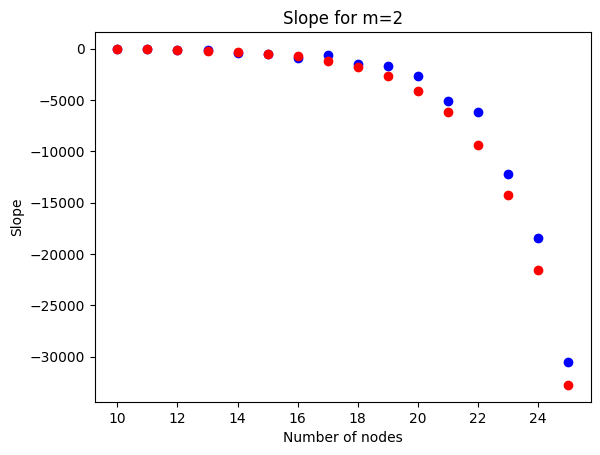

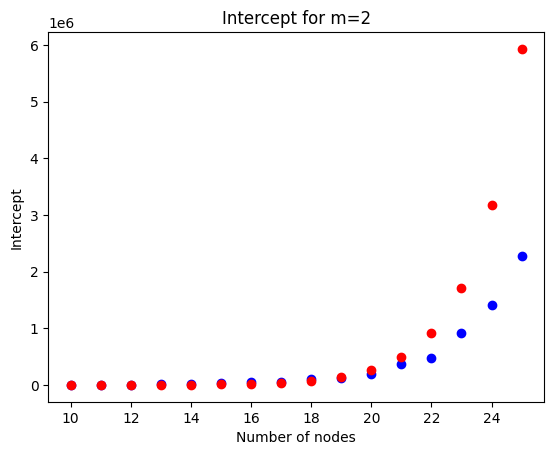

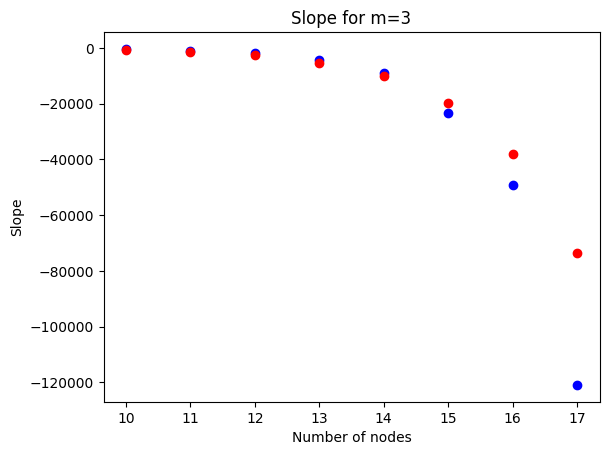

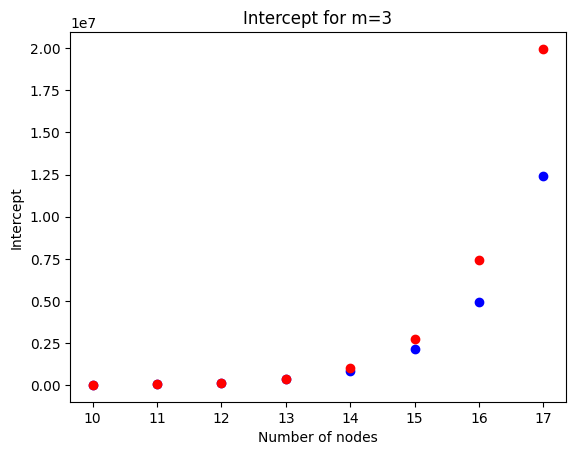

In [151]:
input_data = {
    2: [10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25],
    3: [10, 11, 12, 13, 14, 15, 16, 17]
}

comparison_data = {}

for m, ns in input_data.items():
    data = {}
    for n in ns:
        results = pickle.load(open(f'calculation-cache/results_{3}_{m}_{n}.pkl', 'rb'))
        
        deg_mult_usages = {}
        for result in results:
            graph = result[0]
            for edge, usage in result[2].items():
                neighbors = list(graph.neighbors(edge[0])) + list(graph.neighbors(edge[1]))
                neighbors.remove(edge[0])
                neighbors.remove(edge[1])
                sum_of_neighbor_degrees = sum([graph.degree(neighbor) for neighbor in neighbors])
                mult = sum_of_neighbor_degrees

                if mult not in deg_mult_usages:
                    deg_mult_usages[mult] = []
                deg_mult_usages[mult].append(usage)

        mults = []
        avg_usages = []
        for mult, usages in deg_mult_usages.items():
            mults.append(mult)
            avg_usages.append(sum(usages) / len(usages))

        slope, intercept, r_value, p_value, std_err = linregress(mults, avg_usages)
        data[n] = (slope, intercept)
    
    def logm(x, m):
        return math.log(x) / math.log(m)

    def get_s(n, m):
        return -m ** (0.6 * n)

    def get_i(n, m):
        return m ** (0.9 * n)

    def coeff_s(s, m, n):
        return logm(-s, m) / n
    
    def coeff_i(i, m, n):
        return logm(i, m) / n
    
    x = []
    s1 = []
    s2 = []
    i1 = []
    i2 = []

    for n in data:
        x.append(n)
        s1.append(data[n][0])
        s2.append(get_s(n, m))
        i1.append(data[n][1])
        i2.append(get_i(n, m))
        
    plt.scatter(x, s1, color='blue')
    plt.scatter(x, s2, color='red')
    plt.xlabel('Number of nodes')
    plt.ylabel('Slope')
    plt.title(f'Slope for m={m}') 
    plt.show()

    plt.scatter(x, i1, color='blue')
    plt.scatter(x, i2, color='red')
    plt.xlabel('Number of nodes')
    plt.ylabel('Intercept')
    plt.title(f'Intercept for m={m}')
    plt.show()

    comparison_data[m] = (x, s1, s2, i1, i2)

In [ ]:
%%script echo skipping 

REPEATS = 10

NEIGHBOURS_NUMBER_LOW = 1
NEIGHBOURS_NUMBER_HIGH = 10
NEIGHBOURS_NUMBER_STEP = 1

INITIAL_NODES = 10
FINAL_NODES_LOW = 100
FINAL_NODES_HIGH = 10500
FINAL_NODES_STEP = 500
EDGES_PER_NODE_LOW = 1
EDGES_PER_NODE_HIGH = 10
EDGES_PER_NODE_STEP = 1

max_deg_data = {}
density_data = {}
for nn in range(NEIGHBOURS_NUMBER_LOW, NEIGHBOURS_NUMBER_HIGH + 1, NEIGHBOURS_NUMBER_STEP):
    print(f'nn = {nn}')
    max_deg_data_per_nn = {}
    density_data_per_nn = {}
    for m in range(EDGES_PER_NODE_LOW, EDGES_PER_NODE_HIGH + 1, EDGES_PER_NODE_STEP):
        print(f'm = {m}')
        graph_size = []
        max_deg = []
        avg_deg = []
        for n in range(FINAL_NODES_LOW, FINAL_NODES_HIGH + 1, FINAL_NODES_STEP):
            max_deg_sum = 0
            avg_deg_sum = 0
            for _ in range(REPEATS):
                graph = generate_graph(INITIAL_NODES, n, m)

                degree_dict = dict(graph.degree())
                top_degree_node = max(degree_dict, key=degree_dict.get)

                nodes_within_k_distance = nx.single_source_shortest_path_length(graph, top_degree_node, cutoff=nn)
                subgraph_nodes = list(nodes_within_k_distance.keys())
                subgraph = graph.subgraph(subgraph_nodes)

                max_deg_sum += graph.degree(top_degree_node)
                avg_deg_sum += (subgraph.number_of_edges() / subgraph.number_of_nodes())
            
            graph_size.append(n)
            max_deg.append(max_deg_sum / REPEATS)
            avg_deg.append(avg_deg_sum / REPEATS)

        max_deg_data_per_nn[m] = {'graph_size': graph_size, 'max_deg': max_deg}
        density_data_per_nn[m] = {'graph_size': graph_size, 'avg_deg': avg_deg}

    max_deg_data[nn] = max_deg_data_per_nn
    density_data[nn] = density_data_per_nn

with open('calculation-cache/neighbour-max-deg.pkl', 'wb') as f:
    pickle.dump(max_deg_data, f)

with open('calculation-cache/neighbour-density.pkl', 'wb') as f:
    pickle.dump(density_data, f)

skipping


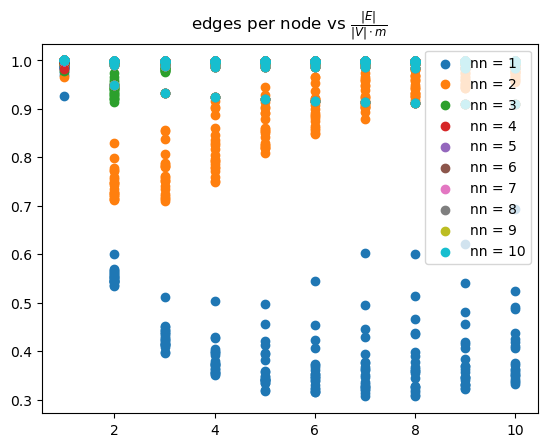

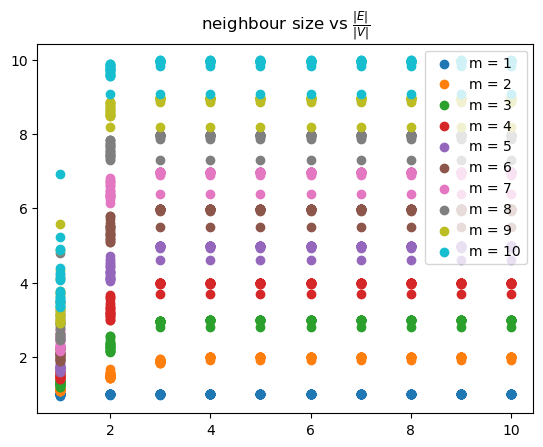

In [ ]:
COLORS = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd", "#8c564b", "#e377c2", "#7f7f7f", "#bcbd22", "#17becf"]

with open('calculation-cache/neighbour-max-deg.pkl', 'rb') as f:
    max_deg_data = pickle.load(f)

with open('calculation-cache/neighbour-density.pkl', 'rb') as f:
    density_data = pickle.load(f)

nn_values = list(density_data.keys())
m_values = list(density_data[nn_values[0]].keys())
n_values = density_data[nn_values[0]][m_values[0]]['graph_size']

# for nn in nn_values:
#     for m in m_values:
#         plt.plot(density_data[nn][m]['graph_size'], density_data[nn][m]['avg_deg'], label=f'm = {m}', color=COLORS[m - 1])
#     plt.title(r"$|V_0|$ vs $\frac{|E|}{|V|}$ for neighbour size = " + str(nn))
#     plt.legend()
#     plt.show()

# for nn in nn_values:
#     for m in m_values:
#         edges_number = [n * m for n in density_data[nn][m]['graph_size']]
#         plt.plot(edges_number, density_data[nn][m]['avg_deg'], label=f'm = {m}', color=COLORS[m - 1])
#     plt.title(r"$|E_0|$ vs $\frac{|E|}{|V|}$ for neighbour size = " + str(nn))
#     plt.legend()
#     plt.show()

# for m in m_values:
#     for nn in nn_values:
#         plt.plot(density_data[nn][m]['graph_size'], density_data[nn][m]['avg_deg'], label=f'nn = {nn}', color=COLORS[nn - 1])
#     plt.title(r"$|V_0|$ vs $\frac{|E|}{|V|}$ for edges per node = " + str(m))
#     plt.legend()
#     plt.show()

# for m in m_values:
#     for nn in nn_values:
#         edges_number = [n * m for n in density_data[nn][m]['graph_size']]
#         plt.plot(edges_number, density_data[nn][m]['avg_deg'], label=f'nn = {nn}', color=COLORS[nn - 1])
#     plt.title(r"$|E_0|$ vs $\frac{|E|}{|V|}$ for edges per node = " + str(m))
#     plt.legend()
#     plt.show()

for nn in nn_values:
    x = []
    y = []
    for m in m_values:
        x.extend([m] * len(density_data[nn][m]['avg_deg']))
        y.extend([d/m for d in density_data[nn][m]['avg_deg']])
    plt.scatter(x, y, label=f'nn = {nn}')
plt.title(r"edges per node vs $\frac{|E|}{|V| \cdot m}$")
plt.legend(loc='upper right')
plt.show()

for m in m_values:
    x = []
    y = []
    for nn in nn_values:
        x.extend([nn] * len(density_data[nn][m]['avg_deg']))
        y.extend(density_data[nn][m]['avg_deg'])
    plt.scatter(x, y, label=f'm = {m}')
plt.title(r"neighbour size vs $\frac{|E|}{|V|}$")
plt.legend(loc='upper right')
plt.show()

# nn_vals = []
# m_vals = []
# y_vals = []
# for nn in nn_values:
#     for m in m_values:
#         for i in range(len(density_data[nn][m]['graph_size'])):
#             nn_vals.append(nn)
#             m_vals.append(m)
#             y_vals.append(density_data[nn][m]['avg_deg'][i])

# plt.scatter(m_vals, y_vals)
# plt.title(r"$\frac{|E|}{|V|}$ vs edges per node")
# plt.show()

# plt.scatter(nn_vals, y_vals)
# plt.title(r"$\frac{|E|}{|V|}$ vs neighbour size")
# plt.show()


In [ ]:
%%script echo skipping 

MAX_DEG_X_FUN = lambda nn, m, n, max_deg: n
MAX_DEG_Y_FUN = lambda nn, m, n, max_deg: max_deg / math.sqrt(n)

with open('calculation-cache/neighbour-max-deg.pkl', 'rb') as f:
    max_deg_data = pickle.load(f)

nn_values = list(max_deg_data.keys())
m_values = list(max_deg_data[nn_values[0]].keys())
n_values = max_deg_data[nn_values[0]][m_values[0]]['graph_size']

for nn in nn_values:
    for m in m_values:
        x = []
        y = []
        for i, n in enumerate(n_values):
            x.append(MAX_DEG_X_FUN(nn, m, n, max_deg_data[nn][m]['max_deg'][i]))
            y.append(MAX_DEG_Y_FUN(nn, m, n, max_deg_data[nn][m]['max_deg'][i]))
        plt.scatter(x, y, label=f'm = {m}', color=COLORS[m - 1])
    plt.title(r"$|V_0|$ vs $\frac{max deg}{f{|V|}}$ for neighbour size = " + str(nn))
    plt.legend(loc='lower right')
    plt.show()

skipping


In [ ]:
%%script echo skipping 

DENSITY_X_FUN = lambda nn, m, n, density: n
DENSITY_Y_FUN = lambda nn, m, n, density: density

with open('calculation-cache/neighbour-density.pkl', 'rb') as f:
    density_data = pickle.load(f)

nn_values = list(density_data.keys())
m_values = list(density_data[nn_values[0]].keys())
n_values = density_data[nn_values[0]][m_values[0]]['graph_size']

for nn in nn_values:
    for m in m_values:
        x = []
        y = []
        for i, n in enumerate(n_values):
            x.append(DENSITY_X_FUN(nn, m, n, density_data[nn][m]['avg_deg'][i]))
            y.append(DENSITY_Y_FUN(nn, m, n, density_data[nn][m]['avg_deg'][i]))
        plt.scatter(x, y, label=f'm = {m}', color=COLORS[m - 1])
    plt.title(r"$|V_0|$ vs $\frac{|E|}{|V|} \cdot \frac{1}{f(|V|)}$ for neighbour size = " + str(nn))
    plt.legend()
    plt.show()

skipping


In [ ]:
%%script echo skipping 

REPEATS = 10

N0 = 10
N = 10000
M = 3

NEIGHBOURS_NUMBER_LOW = 1
NEIGHBOURS_NUMBER_HIGH = 3
NEIGHBOURS_NUMBER_STEP = 1

TOP_DEGREES_NUMBER = 50

density_per_degree_data = {}
for nn in range(NEIGHBOURS_NUMBER_LOW, NEIGHBOURS_NUMBER_HIGH + 1, NEIGHBOURS_NUMBER_STEP):
    print(f'nn = {nn}')
    average_density_per_degree = {}
    average_density_per_degree_counter = {}

    for _ in range(REPEATS):
        graph = generate_graph(N0, N, M)
        degree_dict = dict(graph.degree())
        distinct_degrees = sorted(list(set(degree_dict.values())))[::-1][:TOP_DEGREES_NUMBER]

        for distinct_degree in distinct_degrees:
            if not distinct_degree in average_density_per_degree:
                average_density_per_degree[distinct_degree] = 0
                average_density_per_degree_counter[distinct_degree] = 0

            node_with_degree = [node for node in degree_dict if degree_dict[node] == distinct_degree][0]
            nodes_within_k_distance = nx.single_source_shortest_path_length(graph, node_with_degree, cutoff=nn)
            subgraph_nodes = list(nodes_within_k_distance.keys())
            subgraph = graph.subgraph(subgraph_nodes)
            average_density_per_degree[distinct_degree] += (subgraph.number_of_edges() / subgraph.number_of_nodes())
            average_density_per_degree_counter[distinct_degree] += 1

    degrees = []
    densities = []
    for degree in average_density_per_degree:
        degrees.append(degree)
        densities.append(average_density_per_degree[degree] / average_density_per_degree_counter[degree])
    density_per_degree_data[nn] = {'degrees': degrees, 'densities': densities}    

with open('calculation-cache/neighbour-density-per-degree.pkl', 'wb') as f:
    pickle.dump(density_per_degree_data, f)

skipping


In [ ]:
%%script echo skipping 

with open('calculation-cache/neighbour-density-per-degree.pkl', 'rb') as f:
    density_per_degree_data = pickle.load(f)

for nn, serie in density_per_degree_data.items():
    xs = []
    ys = []
    for i, y in enumerate(serie['densities']):
        xs.append(serie['degrees'][i])
        ys.append(y)
    plt.scatter(xs, ys, label=f'nn = {nn}')
plt.legend()
plt.show()

skipping


In [ ]:
%%script echo skipping 

REPEATS = 100

INITIAL_NODES = 10

FINAL_NODES_LOW = 15
FINAL_NODES_HIGH = 450
FINAL_NODES_STEP = 5

EDGES_PER_NODE_LOW = 2
EDGES_PER_NODE_HIGH = 5
EDGES_PER_NODE_STEP = 1

for m in range(EDGES_PER_NODE_LOW, EDGES_PER_NODE_HIGH+1, EDGES_PER_NODE_STEP):
    print(f'm = {m}')
    for n in range(FINAL_NODES_LOW, FINAL_NODES_HIGH+1, FINAL_NODES_STEP):
        print(f'n = {n}')
        for rep in range(REPEATS):
            graph = generate_graph(INITIAL_NODES, n, m)
            max_deg = max(dict(graph.degree()).values())
            is_planar, subgraph = nx.check_planarity(graph, True)
           
            with open(f'calculation-cache/planarity-reports/report_{m}_{n}_{rep}.pkl', 'wb') as f:
                pickle.dump((is_planar, subgraph), f)

skipping


In [ ]:
%%script echo skipping 

REPEATS = 100

INITIAL_NODES = 10

FINAL_NODES_LOW = 15
FINAL_NODES_HIGH = 450
FINAL_NODES_STEP = 5

EDGES_PER_NODE_LOW = 2
EDGES_PER_NODE_HIGH = 5
EDGES_PER_NODE_STEP = 1

def is_k33(graph):
    return nx.is_isomorphic(graph, nx.complete_bipartite_graph(3, 3))

def is_k5(graph):
    return nx.is_isomorphic(graph, nx.complete_graph(5))

def contract(graph):
    contracted_graph = graph.copy()
    nodes_to_contract = [node for node in contracted_graph.nodes if contracted_graph.degree(node) == 2]
    
    while len(nodes_to_contract) > 0:
        for node in nodes_to_contract:
            neighbors = list(contracted_graph.neighbors(node))
            if len(neighbors) == 2:
                u, v = neighbors
                contracted_graph = nx.contracted_nodes(contracted_graph, u, node, self_loops=False)
        
        nodes_to_contract = [node for node in contracted_graph.nodes if contracted_graph.degree(node) == 2]

    return contracted_graph


planarity_data = {}
for m in range(EDGES_PER_NODE_LOW, EDGES_PER_NODE_HIGH+1, EDGES_PER_NODE_STEP):
    print(f'm = {m}')
    planarity_data[m] = {}
    for n in range(FINAL_NODES_LOW, FINAL_NODES_HIGH+1, FINAL_NODES_STEP):
        planarity_data[m][n] = {'planar': 0, 'non-planar-k5': 0, 'non-planar-k33': 0}
        for rep in range(REPEATS):
            with open(f'calculation-cache/planarity-reports/report_{m}_{n}_{rep}.pkl', 'rb') as f:
                (is_planar, subgraph) = pickle.load(f)

            if is_planar:
                planarity_data[m][n]['planar'] += 1
            else:
                contracted_subgraph = contract(subgraph)
                if is_k33(contracted_subgraph):
                    planarity_data[m][n]['non-planar-k33'] += 1
                elif is_k5(contracted_subgraph):
                    planarity_data[m][n]['non-planar-k5'] += 1
                else:
                    print('ERROR: ', f'calculation-cache/planarity-reports/report_{m}_{n}_{rep}.pkl')
                
with open('calculation-cache/planarity-analysis.pkl', 'wb') as f:
    pickle.dump(planarity_data, f)

skipping


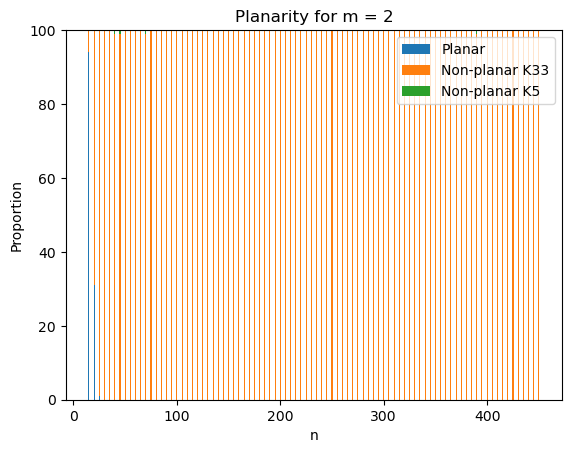

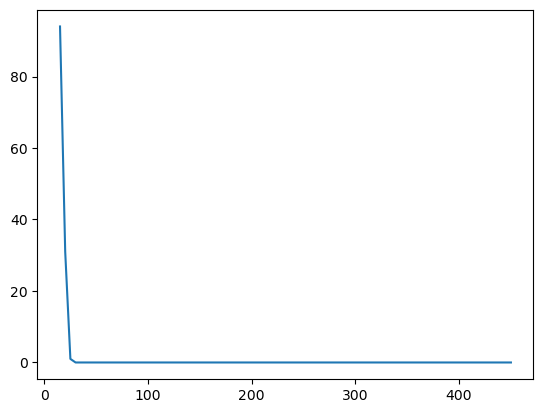

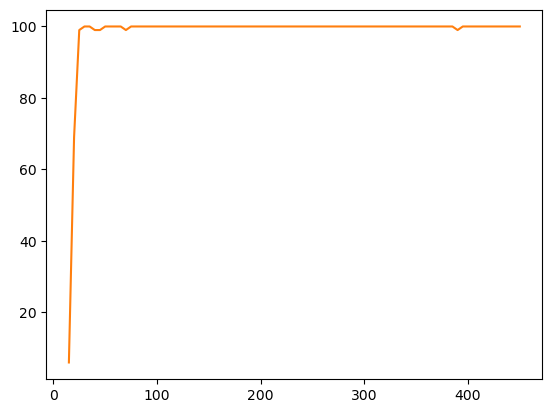

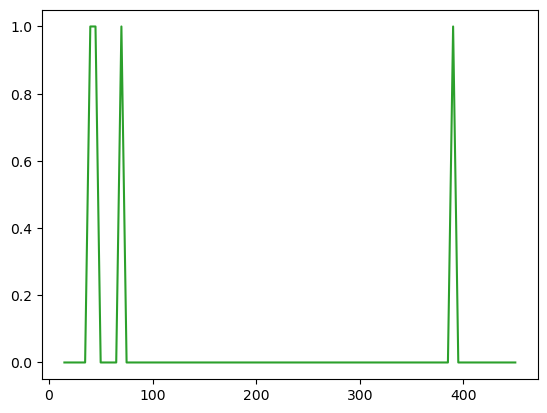

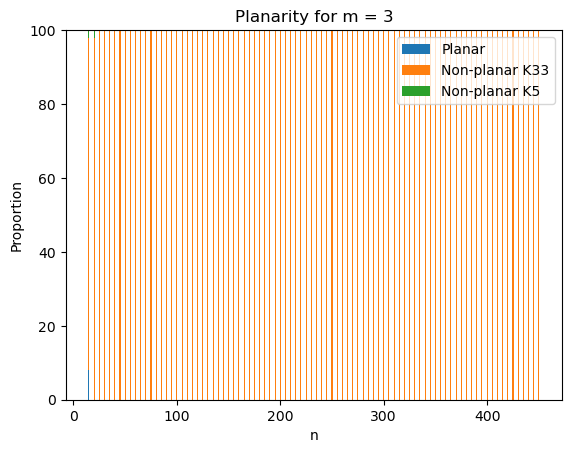

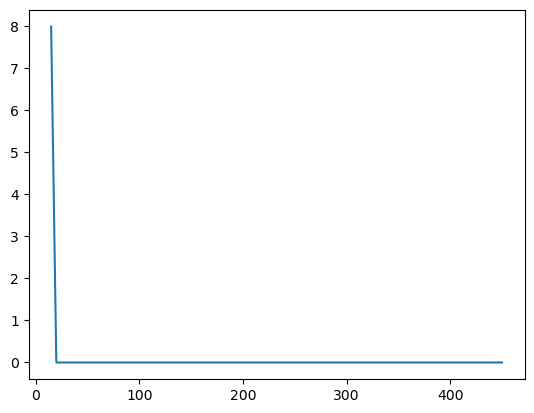

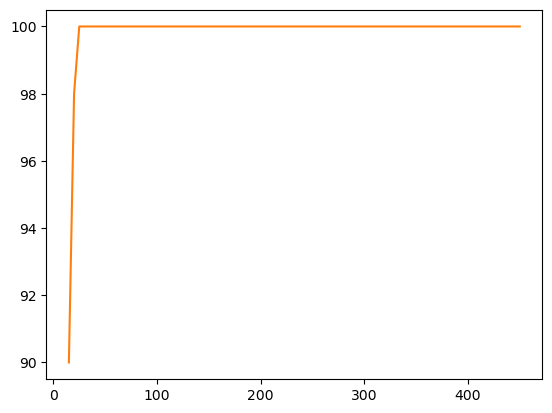

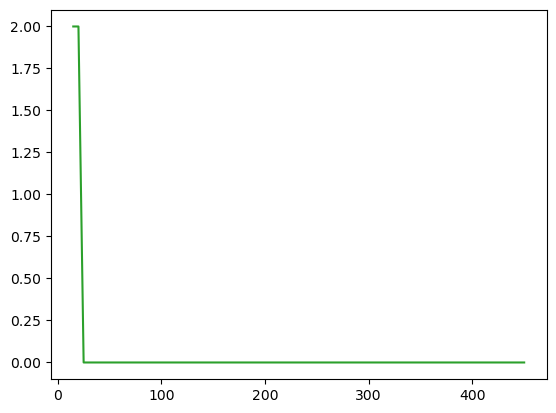

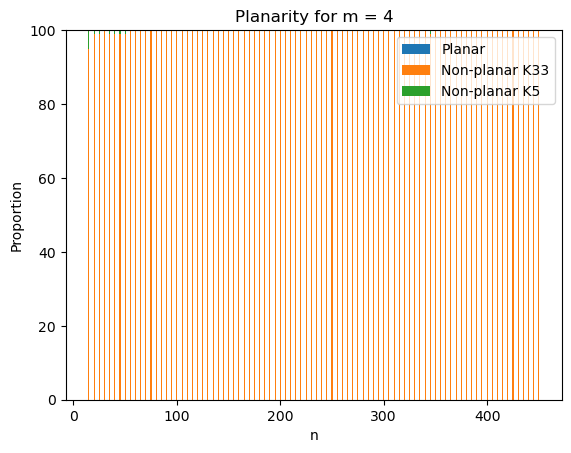

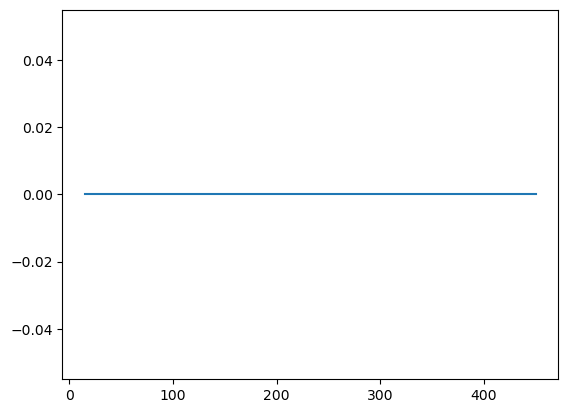

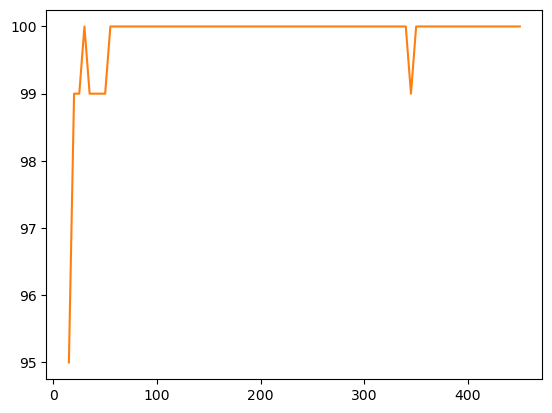

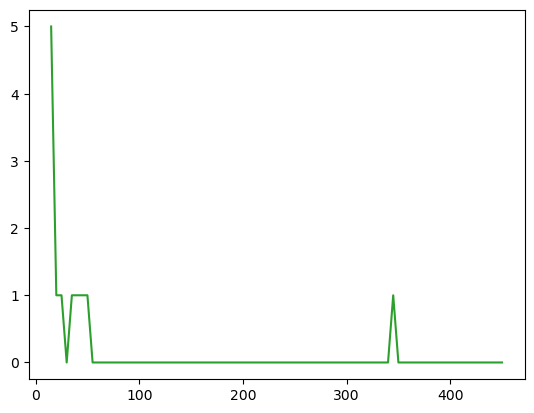

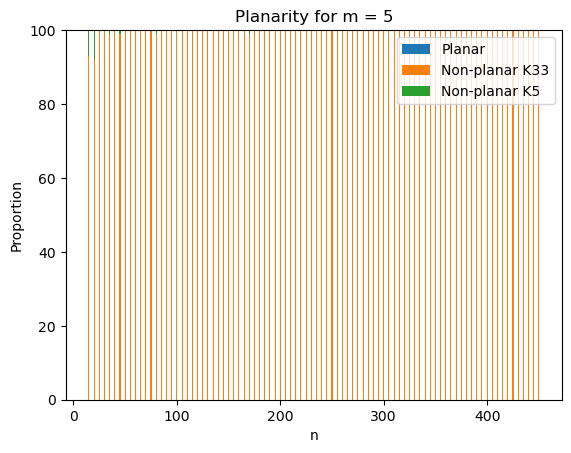

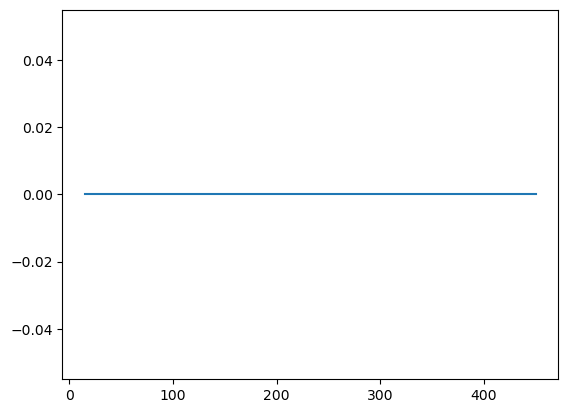

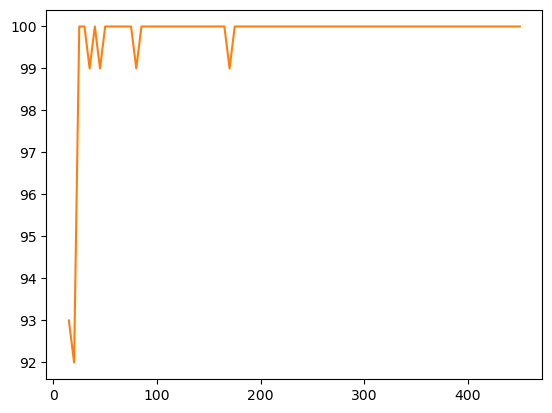

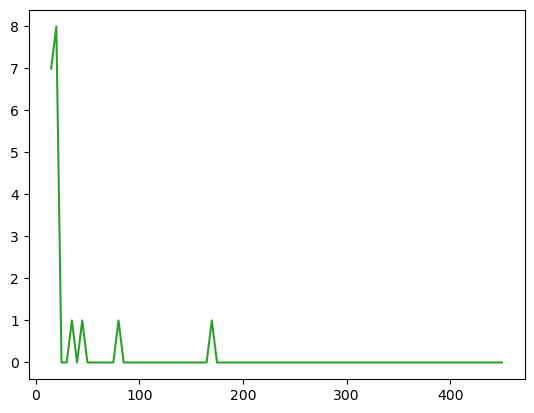

In [ ]:
COLORS = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd", "#8c564b", "#e377c2", "#7f7f7f", "#bcbd22", "#17becf"]

with open('calculation-cache/planarity-analysis.pkl', 'rb') as f:
    planarity_data = pickle.load(f)

for m, data in planarity_data.items():
    x = []
    y_planar = []
    y_non_planar_k5 = []
    y_non_planar_k33 = []
    for n, serie in data.items():
        if n < 500:
            x.append(n)
            y_planar.append(serie['planar'])
            y_non_planar_k5.append(serie['non-planar-k5'])
            y_non_planar_k33.append(serie['non-planar-k33'])
            s = serie['planar'] + serie['non-planar-k5'] + serie['non-planar-k33']
    
    fig, ax = plt.subplots()

    bar_width = 1

    series1 = np.array(y_planar)
    series2 = np.array(y_non_planar_k33)
    series3 = np.array(y_non_planar_k5)

    bottom2 = series1
    bottom3 = series1 + series2

    ax.bar(x, series1, bar_width, label='Planar', color=COLORS[0])
    ax.bar(x, series2, bar_width, bottom=bottom2, label='Non-planar K33', color=COLORS[1])
    ax.bar(x, series3, bar_width, bottom=bottom3, label='Non-planar K5', color=COLORS[2])

    ax.set_xlabel('n')
    ax.set_ylabel('Proportion')
    ax.set_title(f"Planarity for m = {m}")
    ax.legend()
    plt.show()


    plt.plot(x, y_planar, color=COLORS[0])
    plt.show()

    plt.plot(x, y_non_planar_k33, color=COLORS[1])
    plt.show()

    plt.plot(x, y_non_planar_k5, color=COLORS[2])

In [ ]:
%%script echo skipping 

REPEATS = 10

INITIAL_NODES = 10

FINAL_NODES_LOW = 15
FINAL_NODES_HIGH = 100
FINAL_NODES_STEP = 1

EDGES_PER_NODE_LOW = 1
EDGES_PER_NODE_HIGH = 5
EDGES_PER_NODE_STEP = 1

K5 = nx.complete_graph(5)
K33 = nx.complete_bipartite_graph(3, 3)

def find_5_node_cliques(G):
    cliques = []
    for nodes in nx.find_cliques(G):
        if len(nodes) == 5:
            cliques.append(G.subgraph(nodes))
    return cliques

def find_3_full_bipartite(G):
    matcher = nx.isomorphism.GraphMatcher(G, K33)
    K33_subgraphs = []
    
    for subgraph in matcher.subgraph_isomorphisms_iter():
        K33_subgraphs.append(nx.subgraph(G, subgraph.keys()))
    
    return K33_subgraphs

def is_k5_homeomorphic(graph):
    contracted_graph = graph.copy()
    nodes_to_contract = [node for node in contracted_graph.nodes() if contracted_graph.degree(node) == 2]

    for node in nodes_to_contract:
        neighbors = list(contracted_graph.neighbors(node))
        if len(neighbors) == 2:
            u, v = neighbors[0], neighbors[1]
            if contracted_graph.has_edge(u, v):
                contracted_graph.remove_edge(u, node)
                contracted_graph.remove_edge(node, v)
            else:
                contracted_graph.add_edge(u, v)
                contracted_graph.remove_node(node)

    return len(find_5_node_cliques(contracted_graph)) > 0

def is_k33_homeomorphic(graph):
    contracted_graph = graph.copy()
    nodes_to_contract = [node for node in contracted_graph.nodes() if contracted_graph.degree(node) == 2]

    for node in nodes_to_contract:
        neighbors = list(contracted_graph.neighbors(node))
        if len(neighbors) == 2:
            u, v = neighbors[0], neighbors[1]
            if contracted_graph.has_edge(u, v):
                contracted_graph.remove_edge(u, node)
                contracted_graph.remove_edge(node, v)
            else:
                contracted_graph.add_edge(u, v)
                contracted_graph.remove_node(node)

        
    return len(find_3_full_bipartite(contracted_graph)) > 0

planarity_data = {}
for m in range(EDGES_PER_NODE_LOW, EDGES_PER_NODE_HIGH+1, EDGES_PER_NODE_STEP):
    print(f'm = {m}')
    planarity_data[m] = {
        'size': {},
        'max_deg': {}
    }
    for n in range(FINAL_NODES_LOW, FINAL_NODES_HIGH+1, FINAL_NODES_STEP):
        print(f'n = {n}')
        planarity_data[m]['size'][n] = {'planar': 0, 'non-planar-k5': 0, 'non-planar-k33': 0}
        for _ in range(REPEATS):
            graph = generate_graph(INITIAL_NODES, n, m)
            max_deg = max(dict(graph.degree()).values())
            is_planar, subgraph = nx.check_planarity(graph, True)
            if not max_deg in planarity_data[m]['max_deg']:
                planarity_data[m]['max_deg'][max_deg] = {'planar': 0, 'non-planar-k5': 0, 'non-planar-k33': 0}

            if is_planar:
                planarity_data[m]['size'][n]['planar'] += 1
                planarity_data[m]['max_deg'][max_deg]['planar'] += 1
            else:
                if is_k5_homeomorphic(subgraph):
                    planarity_data[m]['size'][n]['non-planar-k5'] += 1
                    planarity_data[m]['max_deg'][max_deg]['non-planar-k5'] += 1

                if is_k33_homeomorphic(subgraph):
                    planarity_data[m]['size'][n]['non-planar-k33'] += 1
                    planarity_data[m]['max_deg'][max_deg]['non-planar-k33'] += 1


with open('calculation-cache/planarity.pkl', 'wb') as f:
    pickle.dump(planarity_data, f)

skipping


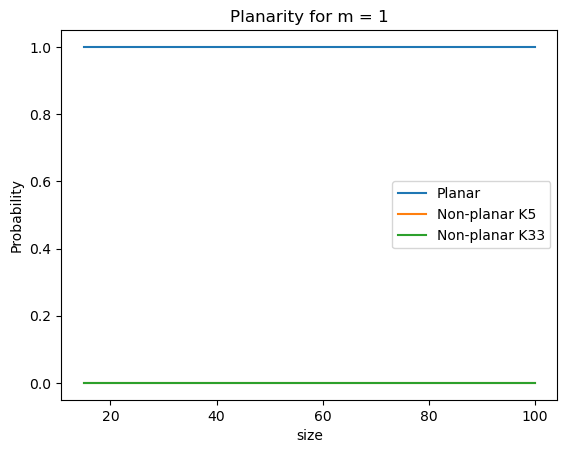

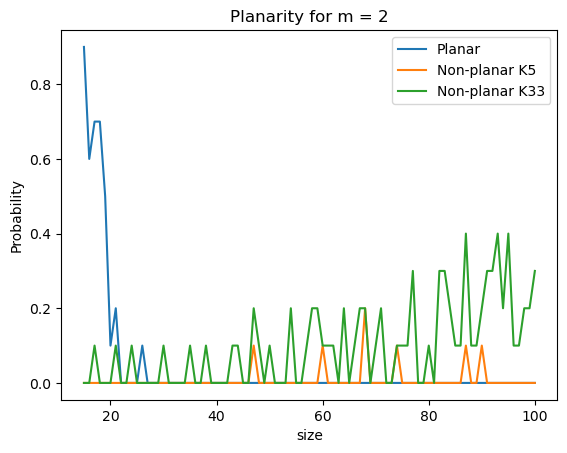

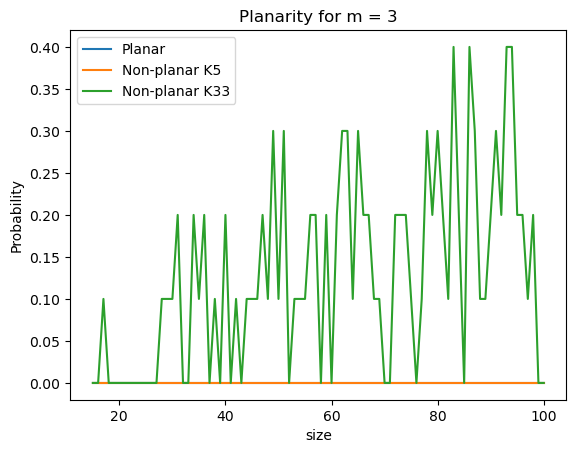

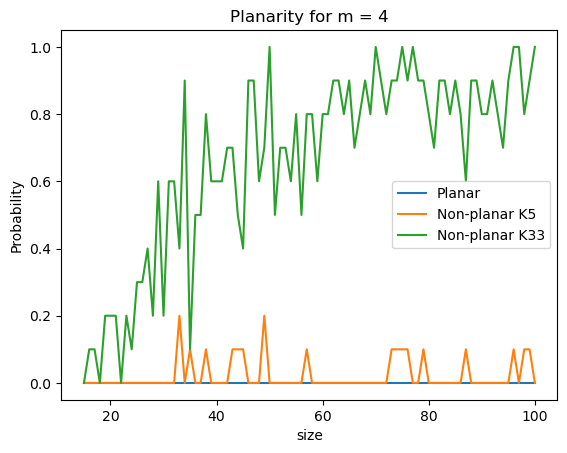

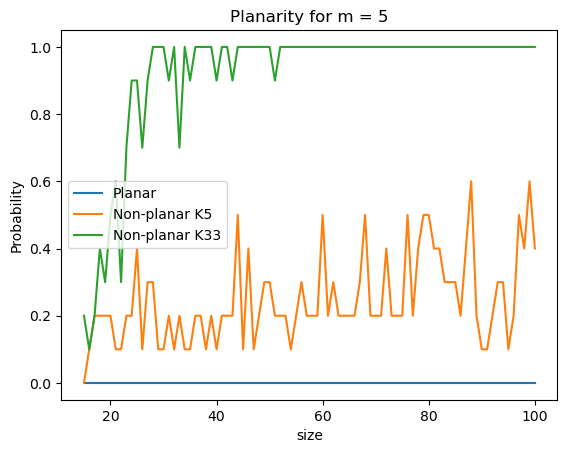

In [ ]:
COLORS = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd", "#8c564b", "#e377c2", "#7f7f7f", "#bcbd22", "#17becf"]
X_PARAM = 'size'
REPEATS = 10

with open('calculation-cache/planarity.pkl', 'rb') as f:
    planarity_data = pickle.load(f)

for m, data in planarity_data.items():
    x = []
    y_planar = []
    y_non_planar_k5 = []
    y_non_planar_k33 = []
    for n, serie in data[X_PARAM].items():
        x.append(n)
        y_planar.append(serie['planar'] / REPEATS)
        y_non_planar_k5.append(serie['non-planar-k5'] / REPEATS)
        y_non_planar_k33.append(serie['non-planar-k33'] / REPEATS)
        s = serie['planar'] + serie['non-planar-k5'] + serie['non-planar-k33']
    
    plt.plot(x, [y for y in y_planar], label='Planar', color=COLORS[0])
    plt.plot(x, [y for y in y_non_planar_k5], label='Non-planar K5', color=COLORS[1])
    plt.plot(x, [y for y in y_non_planar_k33], label='Non-planar K33', color=COLORS[2])
    plt.title(f"Planarity for m = {m}")
    plt.xlabel(X_PARAM)
    plt.ylabel("Probability")
    plt.legend()
    plt.show()

In [ ]:
def has_cycle_of_length_n(graph, n):
    def dfs(node, visited, path):
        visited.add(node)
        path.append(node)

        if len(path) > n:
            visited.remove(node)
            path.pop()
            return False

        for neighbor in graph.get(node, []):
            if neighbor == path[0] and len(path) == n:
                return True
            if neighbor not in visited:
                if dfs(neighbor, visited, path):
                    return True

        visited.remove(node)
        path.pop()
        return False

    for node in graph:
        if dfs(node, set(), []):
            return True

    return False

def has_clique_of_size_n(graph, n):
    if len(graph.keys()) != n:
        return False
    
    for _, value in graph.items():
        if len(value) != n-1:
            return False
        
    return True

def has_complete_bipartite_of_size_n(graph, n):
    for node in graph:
        if len(graph[node]) != n//2:
            return False
        
    G = nx.Graph()
    for node, neighbors in graph.items():
        for neighbor in neighbors:
            G.add_edge(node, neighbor)

    return nx.bipartite.is_bipartite(G)

def count_in_out_degrees_(graph):
    in_degrees = {node: 0 for node in graph}
    out_degrees = {node: 0 for node in graph}
    for node, neighbors in graph.items():
        in_degrees[node] = len([n for n in neighbors if n > node])
        out_degrees[node] = len([n for n in neighbors if n < node])

    return in_degrees, out_degrees

def find_combinations_with_repeats_(target):
    def backtrack(start, path, target):
        if target == 0:
            if len(path) > 0:
                result.append(path)
            return
        for i in range(start, target + 1):
            if i > target:
                break
            backtrack(i, path + [i], target - i)
    
    result = []
    backtrack(1, [], target)
    return result

def find_posibilities_(in_degrees, out_degrees):
    posibilities = {}
    for key in in_degrees.keys():
        posibilities[key] = {}
        posibilities[key]['out'] = ''.join([f'(m-{k})' if k != 0 else 'm' for k in range(out_degrees[key])])
        
    for key, value in in_degrees.items():
        all_combinations = find_combinations_with_repeats_(value)
        
        posibilities[key]['in'] = []
        for comb in all_combinations:
            factor = ''.join([f'(m-{k})' if k != 0 else 'm' for k in range(len(comb))])
            coeff = math.factorial(len(comb))
            for k in set(comb):
                coeff //= math.factorial(comb.count(k))
            if coeff != 1:
                posibilities[key]['in'].append((str(coeff) + factor, comb))
            else:
                posibilities[key]['in'].append((str(factor), comb))
            print('--> ', key, ': ', comb, ' = ', str(coeff) + factor)

    return posibilities


def count_(V, E, check):
    groups = [
        [chr(ord('A') + i)] for i in range(V)
    ]

    group_pairs = list(combinations(range(len(groups)), 2))

    all_edges = []
    for (i, j) in group_pairs:
        for node1, node2 in product(groups[i], groups[j]):
            all_edges.append((node1, node2))

    sorted_all_edges = []
    for edge in all_edges:
        if edge[0][0] > edge[1][0]:
            sorted_all_edges.append(edge)
        else:
            sorted_all_edges.append((edge[1], edge[0]))

    edges_groups = list(combinations(sorted_all_edges, E))

    counter = 0
    for group in edges_groups:
        graph = {chr(ord('A') + i) : [] for i in range(V)}
        for edge in group:
            e1 = edge[0][0]
            e2 = edge[1][0]
            graph[e1].append(e2)
            graph[e2].append(e1)

        if check(graph, V):
            counter += 1
            print(count_in_out_degrees_(graph))
            print(find_posibilities_(*count_in_out_degrees_(graph)))
            for key, values in find_posibilities_(*count_in_out_degrees_(graph)).items():
                value_out = values['out']
                values_in = values['in']
                if len(values_in) == 0:
                    values_in = [('', '[]')]
                for value_in in values_in:
                    print(key + ': ' + value_in[0] + value_out + ': ' + str(value_in[1]))
    
    print(counter)
    print()

# count_(3, 3, has_cycle_of_length_n)
# count_(4, 4, has_cycle_of_length_n)
# count_(5, 10, has_clique_of_size_n)
# count_(6, 9, has_complete_bipartite_of_size_n)

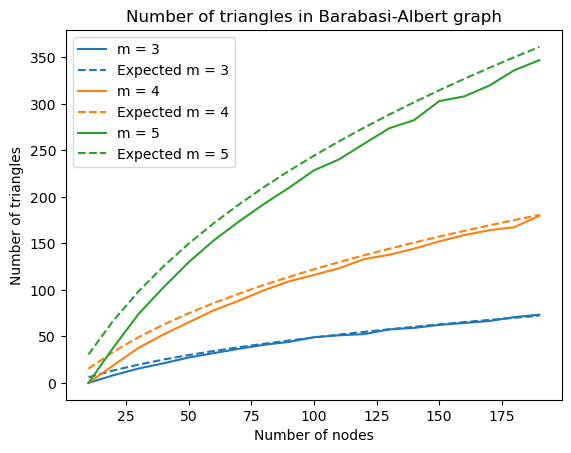

In [ ]:
COLORS = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd", "#8c564b", "#e377c2", "#7f7f7f", "#bcbd22", "#17becf"]
RECALCULATE = False

def k3_expected_number(n, m):
    return (m-1) * m * (m+1) * math.log(n)**3 / 48

for m in [3, 4, 5]:
    if RECALCULATE:
        x = []
        y = []
        for n in range(10, 200, 10):
            print(n)
            n_sum = 0
            for _ in range(1000):
                G = generate_graph(10, n, m)
                triangles = nx.triangles(G)
                total_triangles = sum(triangles.values()) // 3
                n_sum += total_triangles
            x.append(n)
            y.append(n_sum / 1000)
        pickle.dump((x, y), open(f'calculation-cache/k3_data_m_{m}.pkl', 'wb'))
    else:
        x, y = pickle.load(open(f'calculation-cache/k3_data_m_{m}.pkl', 'rb'))
    
    exp_y = [k3_expected_number(n, m) for n in x]
    plt.plot(x, y, label=f'm = {m}', linestyle='-', color=COLORS[m - 3])
    plt.plot(x, exp_y, label=f'Expected m = {m}', linestyle='--', color=COLORS[m - 3])
plt.title("Number of triangles in Barabasi-Albert graph")
plt.xlabel("Number of nodes")
plt.ylabel("Number of triangles")
plt.legend()
plt.show()

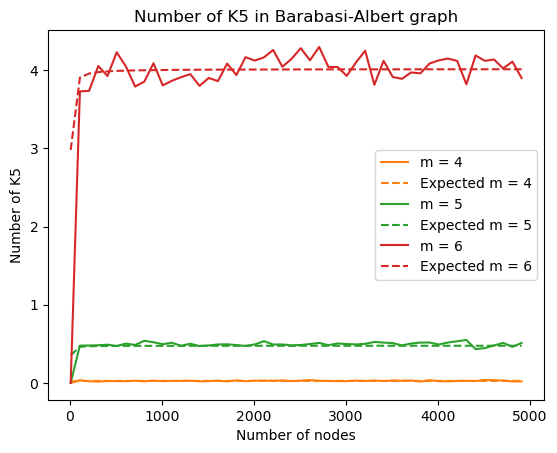

In [ ]:
COLORS = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd", "#8c564b", "#e377c2", "#7f7f7f", "#bcbd22", "#17becf"]
RECALCULATE = False

def harmonic_number(m, n):
    s = 0
    for i in range(1, n+1):
        s += 1 / i**m
    return s

def k5_expected_number(n, m):
    return (m**2-9) * (m**2-4)**2 * (m**2-1)**3 / m**2 * harmonic_number(2, n)**5 / 14745600 / 6.7

for m in [4, 5, 6]:
    if RECALCULATE:
        x = []
        y = []
        for n in range(10, 5000, 100):
            print(n)
            n_sum = 0
            for _ in range(100):
                G = generate_graph(10, n, m)
                cliques = nx.find_cliques(G)
                k5_cliques = [clique for clique in cliques if len(clique) == 5]
                n_sum += len(k5_cliques)
            x.append(n)
            y.append(n_sum / 100)
        pickle.dump((x, y), open(f'calculation-cache/k5_data_m_{m}.pkl', 'wb'))
    else:
        x, y = pickle.load(open(f'calculation-cache/k5_data_m_{m}.pkl', 'rb'))
        
    exp_y = [k5_expected_number(n, m) for n in x]
    plt.plot(x, y, label=f'm = {m}', linestyle='-', color=COLORS[m - 3])
    plt.plot(x, exp_y, label=f'Expected m = {m}', linestyle='--', color=COLORS[m - 3])
plt.title("Number of K5 in Barabasi-Albert graph")
plt.xlabel("Number of nodes")
plt.ylabel("Number of K5")
plt.legend()
plt.show()

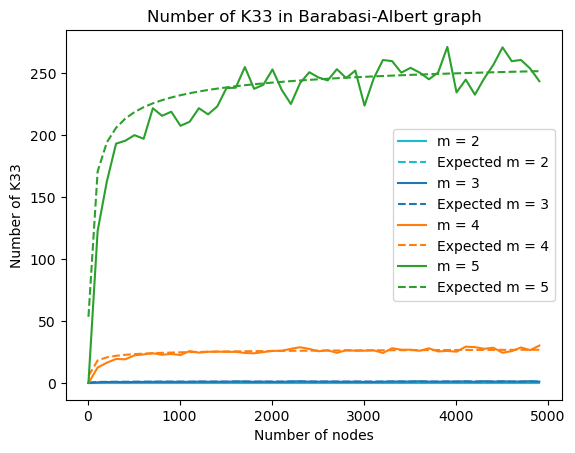

In [ ]:
COLORS = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd", "#8c564b", "#e377c2", "#7f7f7f", "#bcbd22", "#17becf"]
RECALCULATE = False

def harmonic_number(m, n):
    s = 0
    for i in range(1, n+1):
        s += 1 / i**m
    return s

def count_complete_bipartite_subgraphs(graph, k):
    cnt = 0
    for nodes in combinations(graph.nodes, k-1):
        neighbors = set(graph.neighbors(nodes[0]))
        for node in nodes[1:]:
            neighbors.intersection_update(graph.neighbors(node))
        neighbors.difference_update(nodes)

        if len(neighbors) >= k:
            for node in graph.nodes():
                if node <= nodes[-1]:
                    continue
                new_nodes = nodes + (node,)
                if len(set(new_nodes)) != k:
                    continue
                new_neighbors = neighbors.intersection(graph.neighbors(node))
                new_neighbors.difference_update(new_nodes)

                if len(new_neighbors) >= k:
                    cnt += math.comb(len(new_neighbors), k)

    return cnt // 2

# def count_complete_bipartite_subgraphs(graph, k):
#     cnt = 0
#     for nodes in combinations(graph.nodes, k):
#         neighbors = set(graph.neighbors(nodes[0]))
#         for node in nodes[1:]:
#             neighbors.intersection_update(graph.neighbors(node))
#         neighbors.difference_update(nodes)

#         if len(neighbors) >= k:
#             cnt += math.comb(len(neighbors), k)

#     return cnt // 2

def k33_expected_number(n, m):
    return (m**2-1)**2 * (5*m**8-35*m**6+74*m**4-64*m**2+32) / m**3 * harmonic_number(1.5, n)**6 / 2211840 / math.sqrt(5) / 1.6

for m in [2, 3, 4, 5]:
    if RECALCULATE:
        x = []
        y = []
        for n in range(10, 5000, 100):
            print(n)
            n_sum = 0
            for _ in range(100):
                G = generate_graph(10, n, m)
                n_sum += count_complete_bipartite_subgraphs(G, 3)
                
            x.append(n)
            y.append(n_sum / 100)
        pickle.dump((x, y), open(f'calculation-cache/k33_data_m_{m}.pkl', 'wb'))
    else:
        x, y = pickle.load(open(f'calculation-cache/k33_data_m_{m}.pkl', 'rb'))

    exp_y = [k33_expected_number(n, m) for n in x]
    plt.plot(x, y, label=f'm = {m}', linestyle='-', color=COLORS[m - 3])
    plt.plot(x, exp_y, label=f'Expected m = {m}', linestyle='--', color=COLORS[m - 3])
plt.title("Number of K33 in Barabasi-Albert graph")
plt.xlabel("Number of nodes")
plt.ylabel("Number of K33")
plt.legend()
plt.show()

In [ ]:
# Testing correspendence between G(n, m) and G(n*m, 1)

def generate_g1_nm(n0, n, m, colors=None):
    fn = n0 + (n - n0) * m
    graph = generate_graph(n0, fn, 1)

    if colors != None:
        color_index = 0
        for i in range(n0):
            graph.nodes[i]['color'] = colors[color_index]
        color_index += 1
        
        for i in range(n0, fn, m):
            for j in range(m):
                graph.nodes[i + j]['color'] = colors[color_index]
            color_index += 1

    return graph

def fold_g1_nm_to_gm_n(graph, n0, n, m):
    def convert(i):
        return i if i < n0 else n0 + (i - n0) // m

    new_graph = nx.Graph()
    
    fn = n0 + (n - n0) * m
    for i in range(n0):
        new_graph.add_node(i)
        new_graph.nodes[i]['color'] = graph.nodes[i]['color']

    for i in range(n0, fn, m):
        for j in range(m):
            old_id = i + j
            new_id = convert(i)
            
        new_graph.add_node(new_id)
        new_graph.nodes[new_id]['color'] = graph.nodes[old_id]['color']


    converted_edges = [(convert(u), convert(v)) for (u, v) in graph.edges()]
    converted_edges = [(u,v) if u > v else (v,u) for (u,v) in converted_edges]
    initial_edges = [(u,v) for (u,v) in converted_edges if u < n0 and v < n0]
    rest_nodes = [(u,v) for (u,v) in converted_edges if u >= n0 or v >= n0]
    rest_nodes = sorted(rest_nodes, key=lambda x: (x[0], x[1]))

    for u,v in initial_edges:
        new_graph.add_edge(u,v)

    for u,v in rest_nodes:
        new_graph.add_edge(u,v)

    return new_graph
    

# N0 = 10
# N = 100
# M = 5

# colors = ['#000000'] + generate_colors(N - N0, 2)
# initial_graph = generate_g1_nm(N0, N, M, colors)
# merged_graph = fold_g1_nm_to_gm_n(initial_graph, N0, N, M)

# draw_graph(initial_graph)
# draw_graph(merged_graph)

In [ ]:
def generate_gm_n(n0, n, m, colors=None):
    if (n - n0) % m != 0:
        raise ValueError("n - n0 must be divisible by m")
    
    graph = generate_graph(n0, n, m)

    if colors != None:
        color_index = 0
        for i in range(n0):
            graph.nodes[i]['color'] = colors[color_index]
        color_index += 1
        for i in range(n0, n):
            graph.nodes[i]['color'] = colors[color_index]
            color_index += 1

    return graph


def unfold_gm_n_to_g1_nm(graph, n0, n, m):
    new_graph = nx.Graph()

    nodes_translation = {}
    
    for i in range(n0):
        new_graph.add_node(i)
        new_graph.nodes[i]['color'] = graph.nodes[i]['color']
        
    for i in range(n0, n):
        for j in range(n0 + m * (i - n0), n0 + m * (i - n0 + 1)):
            new_graph.add_node(j)
            new_graph.nodes[j]['color'] = graph.nodes[i]['color']

    edges_with_endpoints_less_than_n0 = [(u, v) for u, v in graph.edges() if u < n0 and v < n0]
    for e1, e2 in edges_with_endpoints_less_than_n0:
        new_graph.add_edge(e1, e2)
        nodes_translation[e1] = e1
        nodes_translation[e2] = e2

    for node in range(n0, n):
        edges_to_remove = [(u,v) for u,v in graph.edges(node) if v < u]

        for index, edge in enumerate(edges_to_remove):
            new_start_id = n0 + m * (node - n0)
            new_graph.add_edge(new_start_id + index, nodes_translation[edge[1]])
            nodes_translation[edge[0]] = new_start_id

    return new_graph

# N0 = 5
# N = 101
# M = 3

# colors = ['#000000'] + generate_colors(N - N0, 2)
# initial_graph = generate_gm_n(N0, N, M, colors)
# divided_graph = unfold_gm_n_to_g1_nm(initial_graph, N0, N, M)

# draw_graph(initial_graph)
# draw_graph(divided_graph)

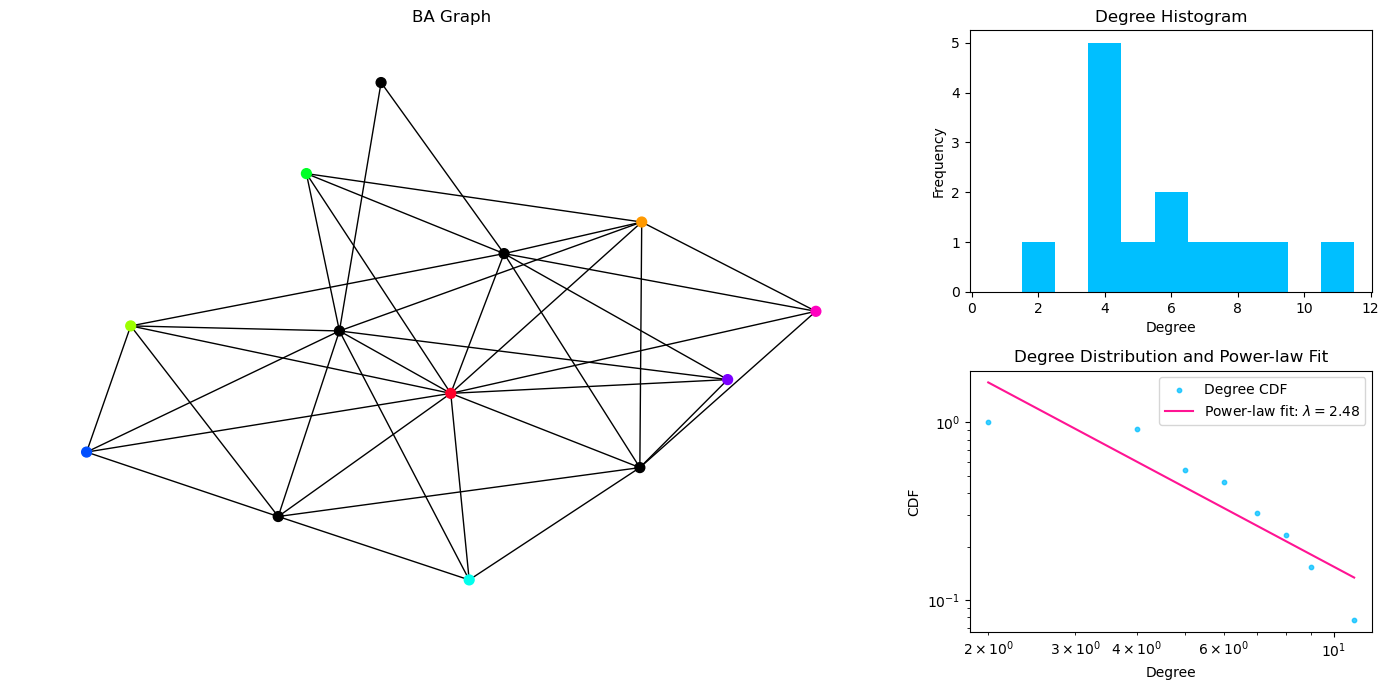

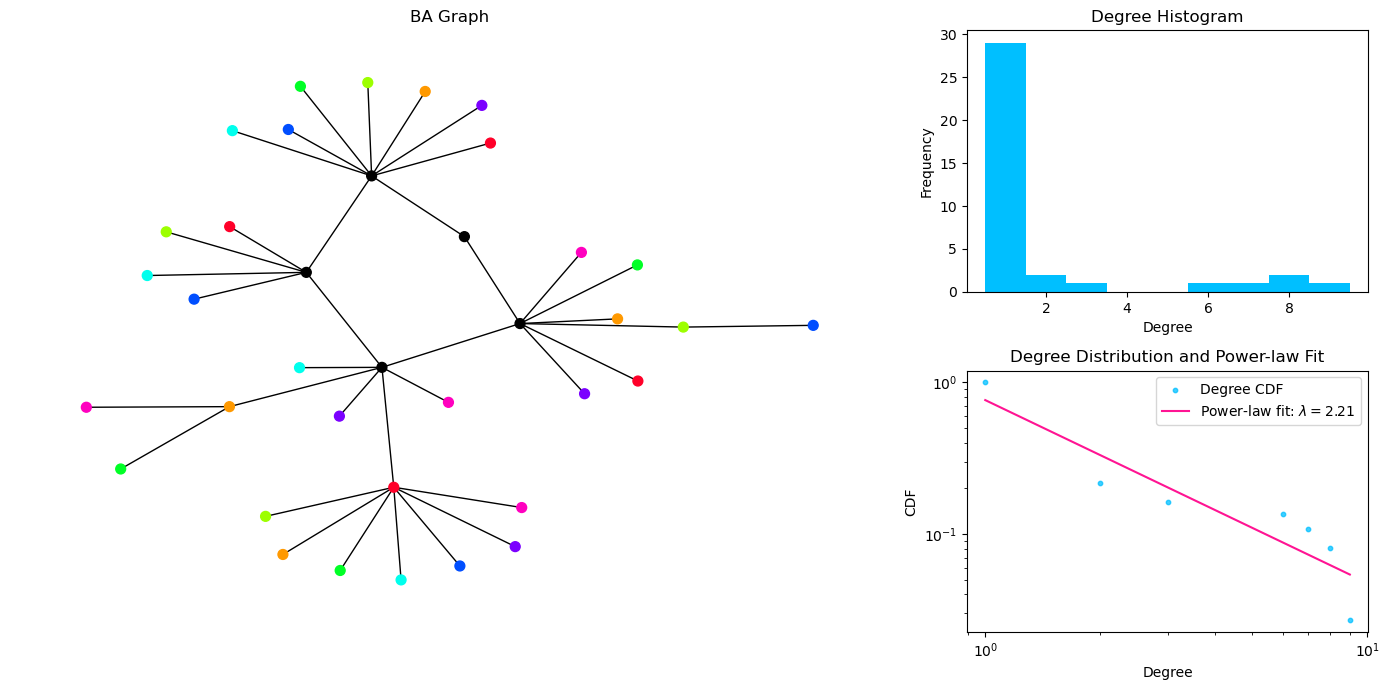

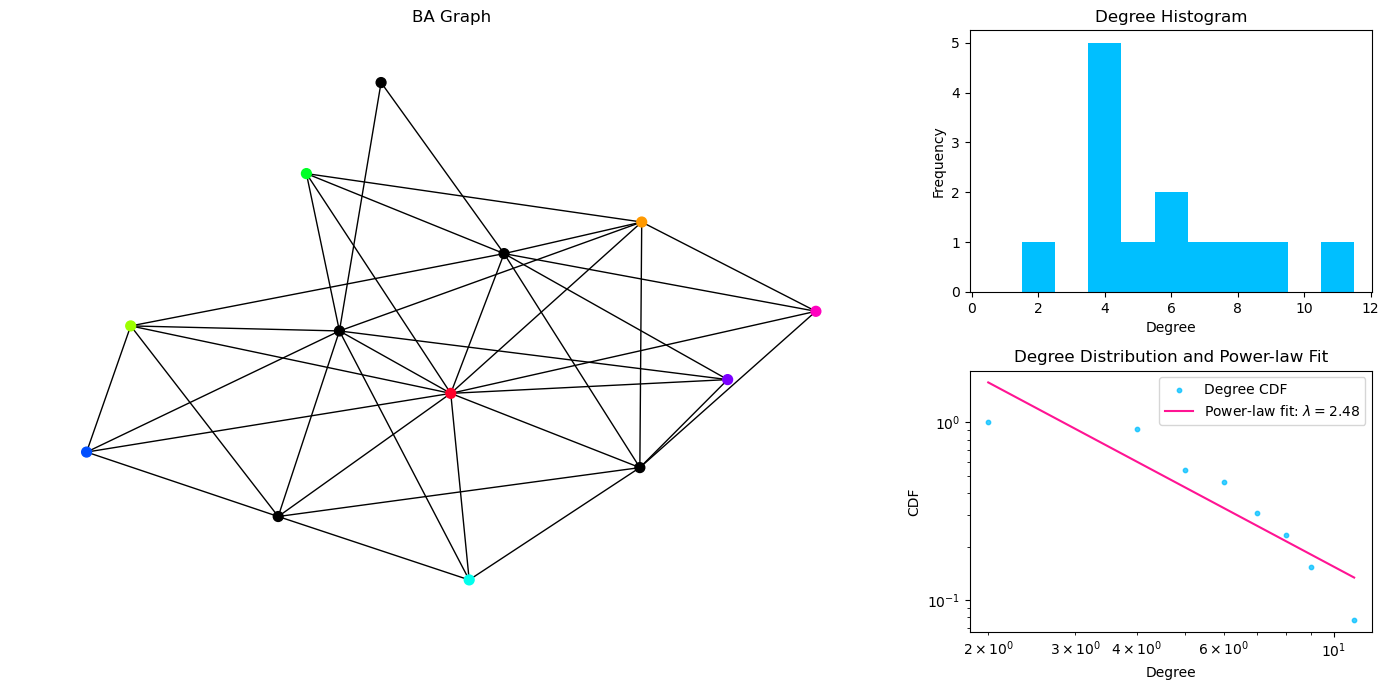

({0: array([ 0.47068427, -0.46544059]),
  1: array([0.14444218, 0.34902172]),
  2: array([-0.15110871,  1.        ]),
  3: array([-0.25118142,  0.05464798]),
  4: array([-0.39826248, -0.65158766]),
  5: array([ 0.01630391, -0.18293839]),
  6: array([0.47517313, 0.46918656]),
  7: array([-0.75271052,  0.07383755]),
  8: array([-0.33052592,  0.6535226 ]),
  9: array([ 0.06058802, -0.89284379]),
  10: array([-0.85873549, -0.4063329 ]),
  11: array([ 0.68164867, -0.13050235]),
  12: array([0.89368435, 0.12942928])},
 13)

In [ ]:
N0 = 5
N = 13
M = 4

colors = ['#000000'] + generate_colors(N - N0, 2)

g1 = generate_gm_n(N0, N, M, colors)
g2 = unfold_gm_n_to_g1_nm(g1, N0, N, M)
g3 = fold_g1_nm_to_gm_n(g2, N0, N, M)

draw_graph(g1)
draw_graph(g2)
draw_graph(g3)